# Named Entity Recognition (NER) Example

This notebook demonstrates how to use the data processing classes and NER functionality implemented in the project.

Índice:


In [1]:
import nltk
from nltk.corpus import conll2002
import spacy
import matplotlib.pyplot as plt
import string
from nltk.tag import CRFTagger
from itertools import combinations
from collections import Counter
from typing import Dict, List, Tuple
import time
import pandas as pd
import seaborn as sns
import numpy as np


## 1. Análisis exploratorio de los datos

First, we'll load data from the conll2002 corpus for Spanish NER.

In [2]:
# CARGAR PRIMERO LOS DATOS DEL TRAIN PARA HACER UN ANALISIS EXPLORATORIO.
train = conll2002.iob_sents('esp.train')

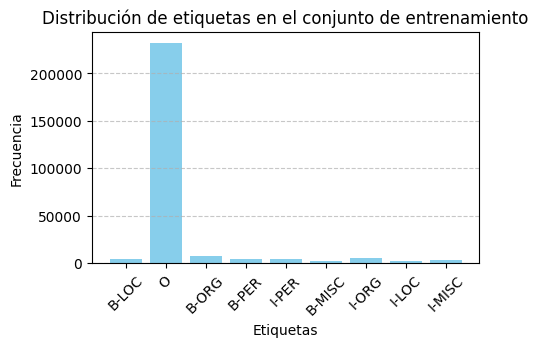

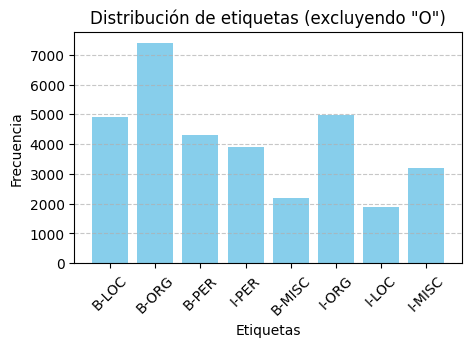

In [3]:
# Contar las etiquetas en el conjunto de entrenamiento
tag_counts = Counter(tag for sentence in train for _, _, tag in sentence)

# Crear una función para graficar
def plot_tag_distribution(tag_counts, title, exclude_tag=None):
    """ Función para graficar la distribución de etiquetas en el conjunto de entrenamiento.
    :param tag_counts: Contador de etiquetas
    :param title: Título del gráfico
    :param exclude_tag: Etiqueta a excluir del gráfico
    """
    if exclude_tag:
        tag_counts = {tag: count for tag, count in tag_counts.items() if tag != exclude_tag}
    plt.figure(figsize=(5, 3))
    plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue')
    plt.xlabel('Etiquetas')
    plt.ylabel('Frecuencia')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Graficar la distribución de todas las etiquetas
plot_tag_distribution(tag_counts, 'Distribución de etiquetas en el conjunto de entrenamiento')

# Graficar la distribución excluyendo la etiqueta "O"
plot_tag_distribution(tag_counts, 'Distribución de etiquetas (excluyendo "O")', exclude_tag="O")


## 3. Explorando los posibles gazzeters

Se va a implementar la clase encargada de construir el diccionario de features sobre los cuales se va a entrenar el modelo CRF.

La clase de funciones de características para NER incluye:

- **Características básicas de las palabras:** se van a incluir las características que vienen por defecto en nltk, ampliando un poco más de información que podemos saber de la palabra. Como por ejemplo, si está formada toda por letras mayusculas, si tiene signos de puntuación, etc.

- **Características contextuales:** incluye aparte de la palabra actual, la palabra que le precede y la posterior.
- **Características de etiquetas POS:** incluye el POS tag de la palabra actual y el de las palabras del contexto.
- **Características de lemas:** incluye el lema de la palabra actual.
- **Características específicas:** Gazetters, listas de patrones específicos.

Esta clase es llamada **OptimizedFeatFunc**, también está optimizada deforma que cada vez que el CRFTagger vuelve a pasar por la misma frase la clase retorna el diccionario de características ya calculado anteriormente, esto evita volver a crear el diccionario.


Las características específicas se van a determinar a partir del train. Se van a formar las listas Gazzeters a partir de los patrones más comunes encontrados. Buscamos las palabras más comunes que aparecen con las etiquetas LOC, ORG, y MISC y, también, los trigramas más comunes que treceden estas etiquetas. De esta manera el modelo podría aprender los patrones más comunes.

In [4]:
train_data = [([token for token, _, _ in sentence], [tag for _, _, tag in sentence]) for sentence in train]

class SimpleGazetteerExtractor:
    """
    Clase para extraer patrones de entidades LOC, ORG, y MISC y analizar trigramas precedentes.
    """
    def __init__(self):
        self.loc_patterns = Counter()
        self.org_patterns = Counter()
        self.misc_patterns = Counter()
        self.trigrams_before_org = Counter()
        self.trigrams_before_loc = Counter()
        self.trigrams_before_misc = Counter()

    def extract_patterns_and_trigrams(self, training_data: List[Tuple[List[str], List[str]]], corpus: List[List[Tuple[str, str, str]]]):
        """
        Extrae patrones de entidades LOC, ORG, y MISC y analiza trigramas precedentes.

        Args:
            training_data: Lista de ejemplos donde cada ejemplo es una tupla (tokens, tags).
            corpus: Lista de oraciones con tokens, etiquetas POS y etiquetas NER.
        """
        # Extraer patrones
        for sentence, tags in training_data:
            current_entity = []
            current_type = None

            for token, tag in zip(sentence, tags):
                if tag.startswith('B-'):
                    if current_entity and current_type:
                        self._store_entity(' '.join(current_entity), current_type)
                    current_entity = [token]
                    current_type = tag[2:]
                elif tag.startswith('I-') and current_type == tag[2:]:
                    current_entity.append(token)
                else:
                    if current_entity and current_type:
                        self._store_entity(' '.join(current_entity), current_type)
                    current_entity = []
                    current_type = None

            if current_entity and current_type:
                self._store_entity(' '.join(current_entity), current_type)

        # Analizar trigramas precedentes
        self._analyze_trigrams(corpus)

    def _store_entity(self, entity: str, entity_type: str):
        """Almacena la entidad en el contador correspondiente."""
        if entity_type == 'LOC':
            self.loc_patterns[entity] += 1
        elif entity_type == 'ORG':
            self.org_patterns[entity] += 1
        elif entity_type == 'MISC':
            self.misc_patterns[entity] += 1

    def _analyze_trigrams(self, corpus: List[List[Tuple[str, str, str]]]):
        """Analiza los trigramas que preceden a organizaciones, lugares y misceláneos."""
        for sentence in corpus:
            for i in range(len(sentence)):
                _, _, ner_tag = sentence[i]

                if ner_tag == 'B-ORG' and i >= 3:
                    trigram = (
                        sentence[i-3][0],
                        sentence[i-2][0],
                        sentence[i-1][0]
                    )
                    self.trigrams_before_org[trigram] += 1

                if ner_tag == 'B-LOC' and i >= 3:
                    trigram = (
                        sentence[i-3][0],
                        sentence[i-2][0],
                        sentence[i-1][0]
                    )
                    self.trigrams_before_loc[trigram] += 1

                if ner_tag == 'B-MISC' and i >= 3:
                    trigram = (
                        sentence[i-3][0],
                        sentence[i-2][0],
                        sentence[i-1][0]
                    )
                    self.trigrams_before_misc[trigram] += 1

    def print_patterns_and_trigrams(self):
        """Imprime los patrones y trigramas más comunes encontrados."""
        print("=== Top 30 Patrones de LOC ===")
        for entity, freq in self.loc_patterns.most_common(30):
            print(f"{entity}: {freq}")

        print("\n=== Top 30 Patrones de ORG ===")
        for entity, freq in self.org_patterns.most_common(30):
            print(f"{entity}: {freq}")

        print("\n=== Top 30 Patrones de MISC ===")
        for entity, freq in self.misc_patterns.most_common(30):
            print(f"{entity}: {freq}")

        print("\n=== Top 30 Trigramas que preceden a organizaciones ===")
        for trigram, freq in self.trigrams_before_org.most_common(30):
            print(f"{trigram[0]} {trigram[1]} {trigram[2]}: {freq}")

        print("\n=== Top 30 Trigramas que preceden a lugares ===")
        for trigram, freq in self.trigrams_before_loc.most_common(30):
            print(f"{trigram[0]} {trigram[1]} {trigram[2]}: {freq}")

        print("\n=== Top 30 Trigramas que preceden a misceláneos ===")
        for trigram, freq in self.trigrams_before_misc.most_common(30):
            print(f"{trigram[0]} {trigram[1]} {trigram[2]}: {freq}")


# Crear el extractor y procesar los datos
extractor = SimpleGazetteerExtractor()
extractor.extract_patterns_and_trigrams(train_data, train)

# Imprimir los patrones y trigramas encontrados
extractor.print_patterns_and_trigrams()


=== Top 30 Patrones de LOC ===
Madrid: 221
España: 147
Barcelona: 99
París: 97
Francia: 58
Líbano: 47
Badajoz: 43
Santander: 40
Mérida: 40
Cáceres: 40
Europa: 37
Brasil: 37
Cataluña: 35
Sevilla: 32
México: 32
Oviedo: 32
Bruselas: 31
Argentina: 30
Navarra: 30
EEUU: 29
Pamplona: 28
Valencia: 27
Río de Janeiro: 27
Israel: 26
Bilbao: 26
Extremadura: 25
San Sebastián: 25
Vitoria: 25
Málaga: 25
Nueva York: 25

=== Top 30 Patrones de ORG ===
EFE: 905
Gobierno: 237
PP: 152
EFECOM: 85
UE: 77
Real Madrid: 73
Efe: 70
Valencia: 67
PSOE: 64
Estado: 63
Ejército: 59
Congreso: 57
Estados Unidos: 55
China: 47
Ejecutivo: 47
Ayuntamiento: 41
ESL: 39
Telefónica: 38
ONU: 34
IU: 33
Unión Europea: 33
CiU: 32
Guardia Civil: 31
Hizbulá: 30
Francia: 30
ETA: 29
España: 29
Parlamento: 28
Administración: 27
Israel: 26

=== Top 30 Patrones de MISC ===
Liga de Campeones: 35
Internet: 33
Interior: 33
Cultura: 18
Medio Ambiente: 18
Agricultura: 15
Educación: 13
Exteriores: 12
Copa de Europa: 12
Justicia: 12
Liga: 12
C

Existe un solapamiento entre las palabras más comunes que identifican los lugares y las organizaciones. Por ejemplo, "Valencia" puede estar identificada en el texto como 'B-LOC' o 'B-ORG'. Decidimos no incluir estas palabras que son comunes para las dos etiquetas.

Si se incluyen las palabras más comunes para la categoría 'B-MISC' pueden introducir mucho ruido en el modelo ya que no se presenta un patrón específico claro, estas palabras podrían pertenecer perfectamente a otras categorias.

Además, como podemos ver, los trigramas que preceden las etiquetas de inicio de organización presentan mucha variablidad, no existe un patrón claro que puede identificar rapidamente la continuación de las entidades que son organizaciones. Aún más variablilidad presentan los trigramas precedentes a los lugares y los micelános, se decide que estos no valen la pena a ser incluidos ya que, también, podrian agregar ruido al modelo.


COMO FUNCIONA EL FLOW : CREAR CRF CON OPTFEATFUNC (que feats usar) => train (datos) => CRF irá llamando a OPTFEAT para cada frase (idx itera sobre las palabras) => tag con el tagger de pycrfsuite.

In [5]:
class OptimizedFeatFunc:
    def __init__(self, use_Basic: bool = True, use_context_words: bool = True, use_contex_POS_tag: bool = True, use_specific_caracteristics: bool = True, use_lemas: bool = True):
        """
        Constructor de la clase de las funciones de características para el CRFTagger.
        Uso:
        - use_Basic: Si se deben usar características básicas (longitud, mayúsculas, etc.)
        - use_context_words: Si se deben usar palabras de contexto (palabra anterior y siguiente)
        - use_contex_POS_tag: Si se deben usar etiquetas POS de contexto (etiqueta anterior y siguiente)
        - use_specific_caracteristics: Si se deben usar características específicas (Gazetteer)
        - use_lemas: Si se deben usar lemas (forma base de la palabra)
       
        """
        self.use_basic_features = use_Basic
        self.use_context = use_context_words
        self.use_conext_POS_tags = use_contex_POS_tag
        self.use_specific_caracteristics = use_specific_caracteristics
        self.use_lema = use_lemas
        
    
        self.ciudades = {"Madrid", "España", "Barcelona", "París", "Líbano", "Badajoz", "Santander", "Mérida", "Cáceres", "Europa", "Brasil", "Cataluña"}
        self.organizaciones_comunes = {"EFE", "Gobierno", "PP", "EFECOM", "UE", "Real Madrid", "Efe",  "PSOE", "Estado", "Ejército", "Congreso",  "Ejecutivo", "Ayuntamiento", "ESL", "Telefónica", "ONU", "IU", "Unión Europea", "CiU", "Guardia Civil", "Hizbulá", "ETA"}

        self.common_org_precedents = {
            "presidente de la",
            "El presidente del"
            "el presidente del",
            "el presidente de",
            "El presidente de"
            "el portavoz del",
            "El portavoz del",
            "general de la",
            "fuentes de la",
            "director general de",
            'miembros de la',
            'representantes de la',
            'secretario general de'
        }
        
        # Cache para resultados
        self.cache = {}
        

    def __call__(self, tokens: list, idx: int) -> dict:
        # Obtener la clave única para la oración actual
        sentence_key = tuple(tokens) # se convierte a tupla porque las tuplas son inmutables
        
        # Clave única para caché
        cache_key = (sentence_key, idx)
        
        # Verificar si ya calculamos este caso
        if cache_key in self.cache:
            return self.cache[cache_key]
        
        feats = {}
        
        if idx >= len(tokens) or idx < 0:
            self.cache[cache_key] = feats
            return feats
            
        word = tokens[idx][0]

        if self.use_basic_features:
            # Características básicas
            feats["word"] = word
            feats["length"] = len(word)
            
            # Características calculadas una sola vez
            if any(char.isdigit() for char in word):
                feats["has_number"] = True
                
            if word and word[0].isupper():
                feats["is_capitalized"] = True
                
            if any(c in string.punctuation for c in word):
                feats["punctuated"] = True
                
            if len(word) > 1:
                feats["suffix"] = word[-2:]
                feats['prefix'] = word[:2]
                
            if word and word.isupper():
                feats['all_capital'] = True

        if self.use_context:
            feats["word"] = word
            if idx >= 1 and idx < len(tokens)-1:
                feats["prev_word"] = tokens[idx-1][0]
                feats["next_word"] = tokens[idx+1][0]


        if self.use_conext_POS_tags:
            
            pos = tokens[idx][1]
            feats["POS"] = pos

            if idx >= 1 and idx < len(tokens)-1:
                
                # Crear trigramas eficientemente
                prev_pos = tokens[idx-1][1]
                next_pos = tokens[idx+1][1]
                
                prev_prev_pos = tokens[idx-2][1] if idx >= 2 else 'START'
                next_next_pos = tokens[idx+2][1] if idx < len(tokens)-2 else 'END'
                
                feats["Prev_POS_2"] = prev_prev_pos
                feats["Prev_POS_1"] = prev_pos
                feats["next_POS_1"] = next_pos
                feats["next_pos_2"] = next_next_pos
                
        if self.use_lema:
           
            lem = tokens[idx][2]
            feats["lema"] = lem
            
            
        if self.use_specific_caracteristics:
            
            if word in self.ciudades:
                feats["is_city"] = True
            
            if word in self.organizaciones_comunes:
                feats["is_organization"] = True
        
            # Verificar precedentes de organización
            if idx >= 3:
                word1 = tokens[idx-3][0]
                word2 = tokens[idx-2][0]
                word3 = tokens[idx-1][0]

                if word1.isdigit() and word2.isalpha() and word3 == "(":
                    feats["organization_precedent"] = True
                else:
                    precedent = f"{word1} {word2} {word3}".lower()
                    if precedent in self.common_org_precedents:
                        feats["organization_precedent"] = True

        # Guardar en caché
        self.cache[cache_key] = feats
        return feats

## 4. Preprocesamiento de Data para CRF Model

Now let's prepare our data for the CRF model, including lemmatization.

In [6]:
from typing import List, Tuple

# Load SpaCy model for Spanish
nlp = spacy.load("es_core_news_sm")

def prepare_data_for_crf(conll_data: List[List[Tuple[str, str, str]]], include_lemmas: bool = True) -> List[List[Tuple[Tuple[str, str, str], str]]]:
    """Process conll data into format for CRF tagging with optional lemmatization.
    
    Args:
        conll_data: List of sentences, where each sentence is a list of tuples (word, pos, tag).
        include_lemmas: Whether to include lemmatization in the processed data.
        
    Returns:
        Processed data in the format required for CRF tagging, that is where each tuple has two arguments.
        In the first argument, the word, pos and lemma (optional) are included, and in the second argument the tag.
    """
    processed_data = []
    
    for sentence in conll_data:
        # Process entire sentence for better lemmatization context
        if include_lemmas:
            text = " ".join(word for word, _, _ in sentence)#works better using the whole sentence (Spacy needs context)
            doc = nlp(text) 
            
            # Create processed sentence
            processed_sentence = []
            for i, (word, pos, tag) in enumerate(sentence):
                if i < len(doc):
                    lemma = doc[i].lemma_
                    processed_sentence.append(((word, pos, lemma), tag))
                else:
                    # Fallback in case of token mismatch
                    processed_sentence.append(((word, pos, word), tag))
        else:
            processed_sentence = [((word, pos), tag) for word, pos, tag in sentence]
            
        processed_data.append(processed_sentence)
    
    return processed_data

Es importante destacar que el usuario debe tener en cuenta que los argumentos de la lematización en el preprocesamiento del texto ("include_lemmas") y en la instancia de la clase OptimizedFeatFunc ("use_lemas") deben de ser los mismos (los dos a True o los dos a False) para el correcto funcionamiento.

## 5. Train a CRF Model for NER

Let's train a small CRF model using our feature function and prepared data.

In [7]:
'''# Create our feature function
feature_func = OptimizedFeatFunc(True,True, True, True, True)

# Initialize CRF tagger with our feature function
crf_tagger = CRFTagger(feature_func=feature_func)

# For demonstration, train on a small subset
crf_tagger.train(processed_train, 'example_model.crf.tagger')

print("CRF model trained!")'''

'# Create our feature function\nfeature_func = OptimizedFeatFunc(True,True, True, True, True)\n\n# Initialize CRF tagger with our feature function\ncrf_tagger = CRFTagger(feature_func=feature_func)\n\n# For demonstration, train on a small subset\ncrf_tagger.train(processed_train, \'example_model.crf.tagger\')\n\nprint("CRF model trained!")'

## 6. NER Evaluation
En este apartado implementamos la evaluación del modelo. La evaluación se realiza sobre el conjunto de test a nivel entidades para tener una medida más robusta y no a nivel de tokens. Esto es importante ya que el modelo puede inventar nuevas entidades y no se puede evaluar su rendimiento a nivel de tokens. La evaluación se realiza utilizando la métrica de F1-score, que es una medida comúnmente utilizada en tareas de NER. Comentar que no se ha considerado las entidades predichas parciales (las que tienen mitad o una parte de la etiqueta correcta), ya que consideramos más objetivo tener una perspectiva más estricta de la evaluación. En este caso, se considera que una entidad es correcta si coincide completamente con la etiqueta esperada.

La implementación ha seguido los siguientes pasos:
1. Extracción de las entidades del conjunto de predicciones para después compararlas con las entidades del conjunto de test extraídas a partir de BIO (tag original).
Instead of just token-level accuracy, let's implement entity-level evaluation.


EVALUARLO POR ENTIDADES, EXTRAYENDO LAS ENTIDADES PARA CADA FRASE EN UN BUCLE.
ACCURACY NO SIRVE PORQUE NO EVALUA LA CAPACIDAD DE INVENTAR NUEVAS ENTIDADES DE UN MODELO.

In [8]:
def extract_BIO(tags):
    entities = []
    entity_type = None
    start_idx = None
    
    for i, tag in enumerate(tags):
        # Handle the case where tag might be a tuple
        if isinstance(tag, tuple):
            tag = tag[1]  # Extract the actual tag if it's a tuple (word, tag)
            
        if tag.startswith('B-'):
            # If we were tracking an entity, add it to the list
            if entity_type is not None:
                entities.append((entity_type, start_idx, i - 1))
            # Start a new entity
            entity_type = tag[2:]  # Remove 'B-' prefix
            start_idx = i
        elif tag.startswith('I-'):
            # Continue with the current entity
            curr_type = tag[2:]  # Remove 'I-' prefix
            # This handles inconsistent I- tags that don't match the current entity
            if entity_type is None or curr_type != entity_type:
                # Close any open entity and ignore this tag (it's an error in tagging)
                if entity_type is not None:
                    entities.append((entity_type, start_idx, i - 1))
                entity_type = None
                start_idx = None
        else:  # 'O' tag
            # If we were tracking an entity, add it to the list
            if entity_type is not None:
                entities.append((entity_type, start_idx, i - 1))
                entity_type = None
                start_idx = None
    
    # Don't forget the last entity if the sequence ends with an entity
    if entity_type is not None:
        entities.append((entity_type, start_idx, len(tags) - 1))
    
    return entities

def extract_IO(tags):
    """
    Extract entities from IO tagging scheme.
    
    Args:
        tags: List of IO tags (e.g., 'I-PER', 'O')
        
    Returns:
        List of tuples (entity_type, start_idx, end_idx)
    """
    entities = []
    entity_type = None
    start_idx = None
    
    for i, tag in enumerate(tags):
        # Handle the case where tag might be a tuple
        if isinstance(tag, tuple):
            tag = tag[1]  # Extract the actual tag if it's a tuple (word, tag)
            
        if tag.startswith('I-'):
            current_type = tag[2:]  # Remove 'I-' prefix
            
            # If not currently tracking an entity OR the entity type changes
            if entity_type is None:
                entity_type = current_type
                start_idx = i
            elif current_type != entity_type:
                # Close current entity and start a new one
                entities.append((entity_type, start_idx, i - 1))
                entity_type = current_type
                start_idx = i
        else:  # 'O' tag
            # If we were tracking an entity, add it to the list
            if entity_type is not None:
                entities.append((entity_type, start_idx, i - 1))
                entity_type = None
                start_idx = None
    
    # Don't forget the last entity if the sequence ends with an entity
    if entity_type is not None:
        entities.append((entity_type, start_idx, len(tags) - 1))
    
    return entities

def extract_BIOE(tags):
    """
    Extract entities from BIOE tagging scheme.
    
    Args:
        tags: List of BIOE tags (e.g., 'B-PER', 'I-PER', 'E-PER', 'O')
        
    Returns:
        List of tuples (entity_type, start_idx, end_idx)
    """
    entities = []
    entity_type = None
    start_idx = None
    
    for i, tag in enumerate(tags):
        # Handle the case where tag might be a tuple
        if isinstance(tag, tuple):
            tag = tag[1]  # Extract the actual tag if it's a tuple
            
        if tag.startswith('B-'):
            # If we were tracking an entity, add it to the list (should not happen in valid BIOE)
            if entity_type is not None:
                entities.append((entity_type, start_idx, i - 1))
            
            # Start a new entity
            entity_type = tag[2:]  # Remove 'B-' prefix
            start_idx = i
        elif tag.startswith('I-'):
            # Continue with the current entity - no change needed
            pass
        elif tag.startswith('E-'):
            # End current entity and add it to list
            if entity_type is not None and entity_type == tag[2:]:
                entities.append((entity_type, start_idx, i))
                entity_type = None
                start_idx = None
            else:
                # Handle error case: E- without matching B-
                entities.append((tag[2:], i, i))
        else:  # 'O' tag
            # If we were tracking an entity, add it to the list (should not happen in valid BIOE)
            if entity_type is not None:
                entities.append((entity_type, start_idx, i - 1))
                entity_type = None
                start_idx = None
    
    # Check for incomplete entity at end (should not happen in valid BIOE)
    if entity_type is not None:
        entities.append((entity_type, start_idx, len(tags) - 1))
    
    return entities

def extract_BIOES(tags):
    """
    Extract entities from BIOES tagging scheme.
    
    Args:
        tags: List of BIOES tags (e.g., 'B-PER', 'I-PER', 'E-PER', 'S-PER', 'O')
        
    Returns:
        List of tuples (entity_type, start_idx, end_idx)
    """
    entities = []
    entity_type = None
    start_idx = None
    
    for i, tag in enumerate(tags):
        # Handle the case where tag might be a tuple
        if isinstance(tag, tuple):
            tag = tag[1]  # Extract the actual tag if it's a tuple
            
        if tag.startswith('B-'):
            # If we were tracking an entity, add it to the list (should not happen in valid BIOES)
            if entity_type is not None:
                entities.append((entity_type, start_idx, i - 1))
            
            # Start a new entity
            entity_type = tag[2:]  # Remove 'B-' prefix
            start_idx = i
        elif tag.startswith('I-'):
            # Continue with the current entity - no change needed
            pass
        elif tag.startswith('E-'):
            # End current entity and add it to list
            if entity_type is not None and entity_type == tag[2:]:
                entities.append((entity_type, start_idx, i))
                entity_type = None
                start_idx = None
            else:
                # Handle error case: E- without matching B-
                entities.append((tag[2:], i, i))
        elif tag.startswith('S-'):
            # Single token entity
            entities.append((tag[2:], i, i))
        else:  # 'O' tag
            # If we were tracking an entity, add it to the list (should not happen in valid BIOES)
            if entity_type is not None:
                entities.append((entity_type, start_idx, i - 1))
                entity_type = None
                start_idx = None
    
    # Check for incomplete entity at end (should not happen in valid BIOES)
    if entity_type is not None:
        entities.append((entity_type, start_idx, len(tags) - 1))
    
    return entities

def extract_BIOW(tags):
    """
    Extract entities from BIOW tagging scheme.
    
    Args:
        tags: List of BIOW tags (e.g., 'B-PER', 'I-PER', 'W-PER', 'O')
        
    Returns:
        List of tuples (entity_type, start_idx, end_idx)
    """
    entities = []
    entity_type = None
    start_idx = None
    
    for i, tag in enumerate(tags):
        # Handle the case where tag might be a tuple
        if isinstance(tag, tuple):
            tag = tag[1]  # Extract the actual tag if it's a tuple
            
        if tag.startswith('B-'):
            # If we were tracking an entity, add it to the list (should not happen in valid BIOW)
            if entity_type is not None:
                entities.append((entity_type, start_idx, i - 1))
            
            # Start a new entity
            entity_type = tag[2:]  # Remove 'B-' prefix
            start_idx = i
        elif tag.startswith('I-'):
            # Continue with the current entity - no change needed
            pass
        elif tag.startswith('W-'):
            # Whole entity (single token)
            entities.append((tag[2:], i, i))
        else:  # 'O' tag
            # If we were tracking an entity, add it to the list
            if entity_type is not None:
                entities.append((entity_type, start_idx, i - 1))
                entity_type = None
                start_idx = None
    
    # Check for incomplete entity at end
    if entity_type is not None:
        entities.append((entity_type, start_idx, len(tags) - 1))
    
    return entities

In [9]:
def extract_entities_types(gold_entities, pred_entities):
    entity_types = set()
    # Add entity types to our set
    for entity_type, _, _ in gold_entities:
        entity_types.add(entity_type)
    for entity_type, _, _ in pred_entities:
        entity_types.add(entity_type)
    return entity_types  # Added return statement

def extract_confusion_matrix(gold_entities, pred_entities):
    """
    Extract confusion matrix for entity recognition.
    
    Args:
        gold_entities: List of gold standard entity tuples (type, start, end)
        pred_entities: List of predicted entity tuples (type, start, end)
        
    Returns:
        Dictionary representing the confusion matrix
    """
    confusion_matrix = {}
    # Build confusion matrix
    # For each gold entity, find if it was correctly predicted
    for gold_entity in gold_entities:
        gold_type, start, end = gold_entity
        
        # Look for predicted entity at the same position
        matched = False
        for pred_entity in pred_entities:
            pred_type, p_start, p_end = pred_entity

            # Check for false positives (predictions without gold)
            # Check if this prediction corresponds to any gold entity
            has_gold = any(g_start == p_start and g_end == p_end for _, g_start, g_end in gold_entities)
            
            if not has_gold:
                confusion_key = ("O", pred_type)  # "O" represents no gold entity
                confusion_matrix[confusion_key] = confusion_matrix.get(confusion_key, 0) + 1

            elif start == p_start and end == p_end:  # Comprobar 
                # Update confusion matrix
                confusion_key = (gold_type, pred_type)
                confusion_matrix[confusion_key] = confusion_matrix.get(confusion_key, 0) + 1
                matched = True
                break
        
        # If no matching prediction was found, it's a false negative
        if not matched:
            confusion_key = (gold_type, "O")  # "O" represents no prediction
            confusion_matrix[confusion_key] = confusion_matrix.get(confusion_key, 0) + 1
                
    return confusion_matrix

    

EL CALCULO DE PRECISION Y RECALL SE HA DESARROLLADO DE LA SIGUIENTE MANERA:


In [10]:
def extract_entities(tags, otherTAG = None):
    """
    Extract entity spans from a sequence of BIO tags.
    
    Args:
        tags: List of BIO tags (e.g., 'B-PER', 'I-PER', 'O')
        
    Returns:
        List of tuples (entity_type, start_idx, end_idx)
    """

    if not otherTAG:
        entities = extract_BIO(tags)

    elif otherTAG == 'IO':
        entities = extract_IO(tags)

    elif otherTAG == 'BIOE':
        entities = extract_BIOE(tags)

    elif otherTAG == 'BIOES':
        entities = extract_BIOES(tags)
    
    elif otherTAG == 'BIOW':
        entities = extract_BIOW(tags)

    return entities
    


def evaluate_entities(gold_entities, pred_entities):
    """
    Calculate precision, recall, and F1 score for entity recognition.
    
    Args:
        gold_entities: List of gold standard entity tuples (type, start, end)
        pred_entities: List of predicted entity tuples (type, start, end)
        
    Returns:
        Dictionary with precision, recall, and F1 scores
    """
    # Convert to sets for easier comparison
    gold_set = set(gold_entities)
    pred_set = set(pred_entities)
    
    # Calculate correct predictions (intersection)
    correct = len(gold_set.intersection(pred_set))
    
    return {
        'gold_count': len(gold_set),
        'pred_count': len(pred_set),
        'correct': correct
    }

def evaluate_ner_corpus(gold_data, predicted_data, otherTAG = None):
    """
    Evaluate NER performance at entity level across an entire corpus.
    
    Args:
        gold_data: List of sentences where each sentence is a list of (tupla, gold_tag) tuples
        predicted_data: List of sentences where each sentence is a list of (word, pred_tag) tuples
        
    Returns:
        Dictionary with overall precision, recall, and F1 scores
    """
    total_correct = 0
    total_gold = 0
    total_pred = 0
    all_confusion_matrix = {}
    all_entity_types = set()
    
    for i in range(len(gold_data)):
        # Extract just the tags
        sentence = gold_data[i]
        sentence_pred = predicted_data[i]
        
        gold_tags = []
        pred_tags = []
        for j in range(len(sentence)):
           # Extrae el tag de cada palabra.
            gold_tags.append(sentence[j][1])
            pred_tags.append(sentence_pred[j][1])
           
        # Extract entities
        gold_entities = extract_entities(gold_tags, otherTAG)
        pred_entities = extract_entities(pred_tags, otherTAG)
        
        # Evaluate this sentence
        results = evaluate_entities(gold_entities, pred_entities)
        sent_confusion_matrix = extract_confusion_matrix(gold_entities, pred_entities)
        sent_entity_types = extract_entities_types(gold_entities, pred_entities)
        
        # Update all entity types and confusion matrix
        all_entity_types.update(sent_entity_types)
        for key, value in sent_confusion_matrix.items():
            all_confusion_matrix[key] = all_confusion_matrix.get(key, 0) + value
    
        # Accumulate counts
        total_correct += results['correct']
        total_gold += results['gold_count']
        total_pred += results['pred_count']
    
    # Calculate overall metrics
    precision = total_correct / total_pred if total_pred > 0 else 0.0 # total_pred incluye las predicciones correctas y las incorrectas y además las predichas "inventadas".
    recall = total_correct / total_gold if total_gold > 0 else 1.0 # total_gold incluye las correctas predichas y las incorrectas y además las que no se han predicho.
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': all_confusion_matrix,
        'entity_types': all_entity_types
    }


# Extend CRFTagger to support entity-level evaluation
def entity_level_accuracy(tagger, test_data, otherTAG = None):
    """
    Calculate entity-level evaluation metrics for a CRFTagger.
    
    Args:
        tagger: Trained CRFTagger model
        test_data: List of sentences where each sentence is a list of ((word, pos, lema), tag) tuples
        
    Returns:
        Dictionary with precision, recall, F1, and accuracy scores
    """
    # Convert test data to the format expected by the evaluation function
    
    # Get predictions
    predicted_data = []
    for sentence in test_data:  # Use original test_data to extract words
        words = [tupla for tupla, _ in sentence]
        tags = tagger.tag(words)
        predicted_data.append(list(zip(words, tags)))
    
    # Evaluate
    results = evaluate_ner_corpus(test_data, predicted_data, otherTAG)

    # Return the data to construct the ConfusionMatrix
    
    
    return results

In [11]:
'''# Replace the token-level accuracy evaluation with entity-level evaluation
entity_metrics = entity_level_accuracy(crf_tagger, preprocessed_val)  # Changed from trained_tagger to crf_tagger

print("Entity-Level Evaluation:")
print(f"Precision: {entity_metrics['precision']:.4f}")
print(f"Recall: {entity_metrics['recall']:.4f}")
print(f"F1 Score: {entity_metrics['f1']:.4f}")

# For comparison, also show the token-level accuracy
# First prepare test data in the format expected by the CRF tagger
token_accuracy = crf_tagger.accuracy(preprocessed_val)  # Changed from trained_tagger to crf_tagger
print(f"\nToken-Level Accuracy: {token_accuracy:.4f}")'''

'# Replace the token-level accuracy evaluation with entity-level evaluation\nentity_metrics = entity_level_accuracy(crf_tagger, preprocessed_val)  # Changed from trained_tagger to crf_tagger\n\nprint("Entity-Level Evaluation:")\nprint(f"Precision: {entity_metrics[\'precision\']:.4f}")\nprint(f"Recall: {entity_metrics[\'recall\']:.4f}")\nprint(f"F1 Score: {entity_metrics[\'f1\']:.4f}")\n\n# For comparison, also show the token-level accuracy\n# First prepare test data in the format expected by the CRF tagger\ntoken_accuracy = crf_tagger.accuracy(preprocessed_val)  # Changed from trained_tagger to crf_tagger\nprint(f"\nToken-Level Accuracy: {token_accuracy:.4f}")'

In [12]:

def plot_confusion_matrix(confusion_matrix: Dict[Tuple[str, str], int], entity_types: set) -> None:
    """Args:
        confusion_matrix: Dictionary with (gold_type, pred_type) keys and counts as values
        entity_types: Set of entity types to include in the matrix
    """

    # Make sure "O" is included for non-entity
    entity_types = sorted(list(entity_types) + ["O"])

    # Create a matrix filled with zeros
    matrix = np.zeros((len(entity_types), len(entity_types)))

    # Map entity types to indices
    type_to_idx = {t: i for i, t in enumerate(entity_types)}

    # Fill the matrix with confusion counts
    for (gold_type, pred_type), count in confusion_matrix.items():
        if gold_type in type_to_idx and pred_type in type_to_idx:
            gold_idx = type_to_idx[gold_type]
            pred_idx = type_to_idx[pred_type]
            matrix[gold_idx, pred_idx] = count

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    # Change fmt from 'd' to 'g' to handle both integers and floats
    sns.heatmap(matrix, annot=True, fmt=".0f", cmap="Blues", 
                xticklabels=entity_types, yticklabels=entity_types)
    plt.title('Entity-Level Confusion Matrix')
    plt.xlabel('Predicted Entity Type')
    plt.ylabel('True Entity Type')
    plt.tight_layout()
    plt.show()

    # Print analysis of most common confusions
    print("\nMost common entity type confusions:")
    confusion_counts = [(gold, pred, count) for (gold, pred), count in confusion_matrix.items()]
    confusion_counts.sort(key=lambda x: x[2], reverse=True)

    for gold, pred, count in confusion_counts[:5]:
        if gold != pred:
            print(f"  {gold} mistaken as {pred}: {count} times")

## 7. Conclusion

This notebook has demonstrated:

1. How to use the `data` class for processing NER data
2. How to implement and customize a feature function
3. How to prepare data for CRF tagging
4. How to convert between different tagging schemes (BIO, IO, BIOES)
5. How to perform entity-level evaluation

These techniques can be applied to improve NER performance for Spanish and other languages.

## 8. Feature Combination Analysis

Let's evaluate different combinations of features to find the optimal configuration using entity-level evaluation metrics instead of token-level accuracy.

PARA SACAR EL MEJOR MODELO SE EVALUA CON LA DATA DE VALIDACIÓN, Y CON EL MEJOR MODELO, PREDECIR PARA LOS TESTS.

In [13]:
def train_completo(processed_train, processed_val):
    # Define feature groups to test
    feature_groups = {
        "Basic": True,        # word, length, etc.
        "Context_Words": True,  # prev_word, next_word
        "Context_POS": True,    # POS tags of surrounding words
        "Specific": True,      # location_suffix, organization_precedent, etc.
        "Lemmas": True,        # Use lemmatization features
    }
    
    # Initialize variables to track best configurations
    best_features = []
    best_scores = []
    best_models = []
    
    print("Starting greedy feature selection...")
    
    # Iterate through feature counts (0 to n) INCLUDING ALSO THE BASELINE (NO FEATURES)
    for r in range(0, len(feature_groups) + 1):
        print(f"\n--- Finding best configuration with {r} features ---")
        
        # In first round, test all individual features
        # In subsequent rounds, only test combinations that include previous best features
        if r == 0:
            # Test no features (baseline)
            candidates = [[]]
        elif r == 1:
            # Test each feature individually
            candidates = [[feat] for feat in feature_groups.keys()]
        else:
            # Keep best features from previous round and test adding one more
            candidates = [best_features[-1] + [feat] for feat in feature_groups.keys() 
                         if feat not in best_features[-1]]
        
        best_config = None
        best_score = 0
        best_model = None
        
        # Test all candidate configurations for this round
        for candidate_features in candidates:
            # Create configuration with only these features enabled
            config = {feat: (feat in candidate_features) for feat in feature_groups.keys()}
            print(f"Testing configuration: {config} out of {len(candidates)}")
            
            # Test this configuration
            start_time = time.time()
            tagger, entity_metrics = evaluate_feature_combination(config, processed_train, processed_val)
            elapsed = time.time() - start_time
            
            # Check if this is the best so far
            f1_score = entity_metrics['f1']
            print(f"F1 Score: {f1_score:.4f}, Time: {elapsed:.2f} seconds")
            
            if f1_score > best_score:
                best_score = f1_score
                best_config = candidate_features
                best_model = tagger
        
        # Save best configuration for this round
        best_features.append(best_config)
        best_scores.append(best_score)
        best_models.append(best_model)
        
        # Save the best model for this round
        if best_model:
            # Generate a descriptive model name with round number and features
            features_str = '_'.join([k[:1] for k, v in {feat: True for feat in best_config}.items()])
            model_path = f'best_model_r{r}_{features_str}.crf.tagger'
            
            # Train and save the best model for this round
            best_model.train(processed_train, model_path)
            print(f"Saved best model with {r} features to {model_path}")
        
        print(f"Best configuration with {r} features: {best_config}")
        print(f"Best F1 score: {best_score:.4f}")
    
    # Print summary of all best configurations
    print("\n=== Summary of Greedy Feature Selection ===")
    for r in range(len(best_features)):
        print(f"Round {r+1}: Best features = {best_features[r]}, F1 score = {best_scores[r]:.4f}")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(best_scores)+1), best_scores, marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Number of Features (Greedy Selection)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return best_features, best_scores, best_models

def evaluate_feature_combination(config, processed_train, processed_val):
    """Evaluate a single feature configuration and return metrics"""
    # Create feature function with the specified configuration
    feat_func = OptimizedFeatFunc(
        use_Basic=config['Basic'], 
        use_context_words=config['Context_Words'], 
        use_contex_POS_tag=config['Context_POS'], 
        use_specific_caracteristics=config['Specific'],
        use_lemas=config['Lemmas']
    )
    
    # Create the CRF tagger with the feature function
    ct = CRFTagger(feature_func=feat_func)
    
    # Create a temporary model file for evaluation
    ct.train(processed_train, 'temp_model.crf.tagger')
    
    # Calculate entity-level metrics
    entity_metrics = entity_level_accuracy(ct, processed_val)
    
    return ct, entity_metrics

**El mejor modelo elegido es el que utiliza 4 características 'Basic', 'Context_Words', 'Lemmas' y 'Specific'.**

### Análisis de los pesos entrenados por el modelo: 

Cada vez añadiendo más información el modelo parece mejorar su capacidad predictiva, pero el modelo con 5 features da un peor rendimiento que el modelo con 4 features. Lo que vemos es que agregando al mejor modelo, que tiene las features 'Basic', 'Context_Words', 'Lemmas' y 'Specific', el contexto de las POS tags empeora el rendimiento.

Podemos fijarnos en el modelo entrenado con todas las features de la clase OptimizedFeatFunc y analizar así el peso que le aporta el modelo a cada feature, y la importáncia que tiene esta, sobretodo de la feature 'Prev_POS_2',"Prev_POS_1", "POS","next_POS_1"y"next_POS_2".

In [ ]:
import pycrfsuite

tagger = pycrfsuite.Tagger()
tagger.open('Modelos_Spanish/best_model_r4_B_C_L_S.crf.tagger')
weights = tagger.info().state_features

In [21]:
feature_general = ["POS"]#'Prev_POS_2', "Prev_POS_1",, "next_POS_1", "next_pos_2"
for k,v in tagger.info().state_features.items():
    e, l = k
    if ":" in e:
        e = e.split(":")[0] #mostar solo aquellas k, v que tienen como e in feature general
        if e in feature_general:
            print(k, v)

('POS:NP', 'B-LOC') 1.163894
('POS:NP', 'O') -2.142094
('POS:NP', 'B-ORG') 0.718814
('POS:NP', 'B-PER') 1.968881
('POS:NP', 'I-PER') -0.013836
('POS:NP', 'B-MISC') -0.448249
('POS:NP', 'I-ORG') -0.275806
('POS:Fpa', 'O') 1.475283
('POS:Fpt', 'O') 1.262104
('POS:Fc', 'O') 2.502387
('POS:Z', 'B-LOC') -0.24656
('POS:Z', 'O') 0.577768
('POS:Z', 'B-ORG') -0.4837
('POS:Z', 'B-MISC') 1.018195
('POS:Z', 'I-ORG') 0.104015
('POS:Z', 'I-LOC') -0.212947
('POS:Z', 'I-MISC') 0.175497
('POS:NC', 'B-LOC') 0.572978
('POS:NC', 'O') -1.01741
('POS:NC', 'B-ORG') -0.461251
('POS:NC', 'B-PER') 0.635075
('POS:NC', 'I-PER') 0.484962
('POS:NC', 'B-MISC') -0.869603
('POS:NC', 'I-ORG') -0.08641
('POS:NC', 'I-LOC') 0.328815
('POS:NC', 'I-MISC') 0.412843
('POS:Fp', 'B-LOC') 0.430038
('POS:Fp', 'O') 5.090399
('POS:Fg', 'O') 2.506659
('POS:DA', 'B-LOC') -0.392068
('POS:DA', 'O') 2.473386
('POS:DA', 'B-ORG') -0.434501
('POS:DA', 'B-PER') -1.133846
('POS:DA', 'I-PER') 0.409231
('POS:DA', 'B-MISC') -0.491541
('POS:DA',

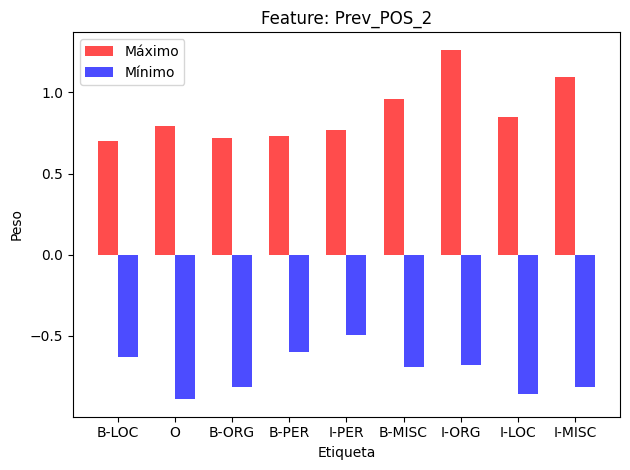

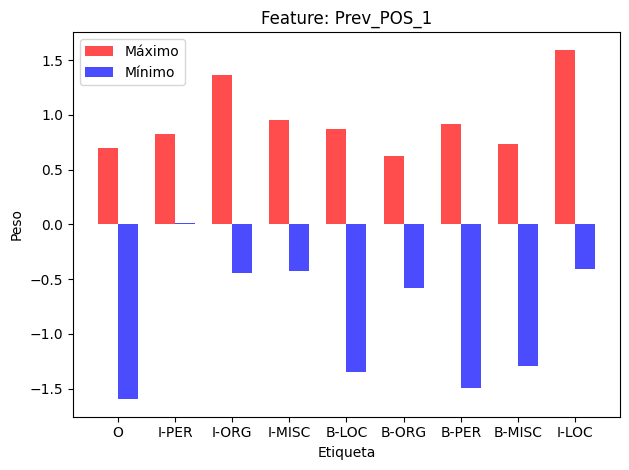

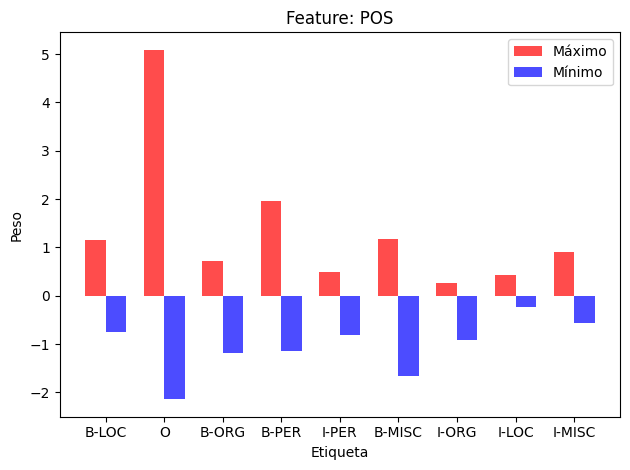

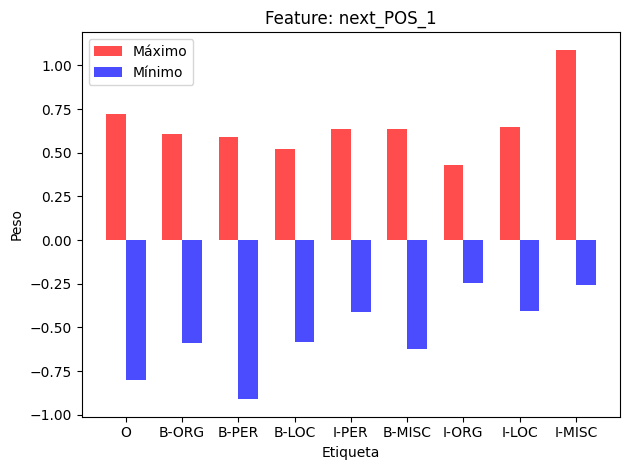

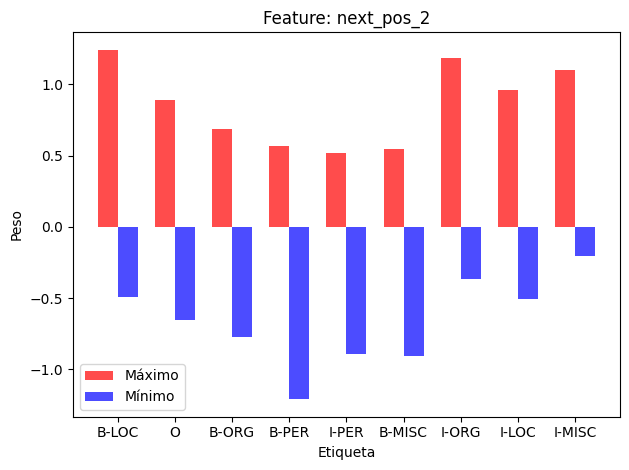

In [28]:
feature_general = ['Prev_POS_2', "Prev_POS_1", "POS", "next_POS_1", "next_pos_2"]
D_POS = {feature: {} for feature in feature_general}  # Diccionario para almacenar los pesos de las features
# Agrupar los pesos por características y etiquetas
for (e, l), v in tagger.info().state_features.items():
    if ":" in e:
        e = e.split(":")[0]
    if e in feature_general:
        D_POS[e].setdefault(l, []).append(v)
# Graficar para cada feature en feature_general el valor máximo y mínimo para cada etiqueta
for f in feature_general:
    D_ = D_POS[f]
    labels = list(D_.keys())
    max_values = [max(v) for v in D_.values()]
    min_values = [min(v) for v in D_.values()]
    # Crear un gráfico de barras
    x = range(len(labels))  # Posiciones en el eje x
    width = 0.35  # Ancho de las barras
    plt.bar(x, max_values, width, label='Máximo', color='red', alpha=0.7)
    plt.bar([p + width for p in x], min_values, width, label='Mínimo', color='blue', alpha=0.7)
    
    plt.title(f"Feature: {f}")
    plt.xlabel("Etiqueta")
    plt.ylabel("Peso")
    plt.xticks([p + width / 2 for p in x], labels)  # Ajustar las etiquetas en el eje x
    plt.legend()
    plt.tight_layout()
    plt.show()

El modelo sí que aporta pesos significativos a las features asociadas a los POS tags del contexto, pero sobretodo la magnitud de los pesos es mayor para los features con POS tag actual.

Por otro lado, podemos intuir que la incorporación de los postags puede introducir algo de ruido en el modelo, por ejemplo:

('POS:NC', 'B-LOC') 0.572978<br>
('POS:NC', 'O') -1.01741<br>
('POS:NC', 'B-ORG') -0.461251<br>
('POS:NC', 'B-PER') 0.635075<br>
('POS:NC', 'I-PER') 0.484962<br>
('POS:NC', 'B-MISC') -0.869603<br>
('POS:NC', 'I-ORG') -0.08641<br>
('POS:NC', 'I-LOC') 0.328815<br>
('POS:NC', 'I-MISC') 0.412843<br>


Los postags asociados a NC tienen un peso bastante parecido para las etiquetas 'B-LOC', 'B-PER', 'I-PER'y 'I-MISC'. Ejemplos como este no le permiten al modelo discriminar bien.

In [29]:
besttagger = pycrfsuite.Tagger()
besttagger.open('NEWbest_model_r4_B_C_L_S.crf.tagger')
best_weights = tagger.info().state_features

Ahora se van a analizar los pesos del mejor modelo:

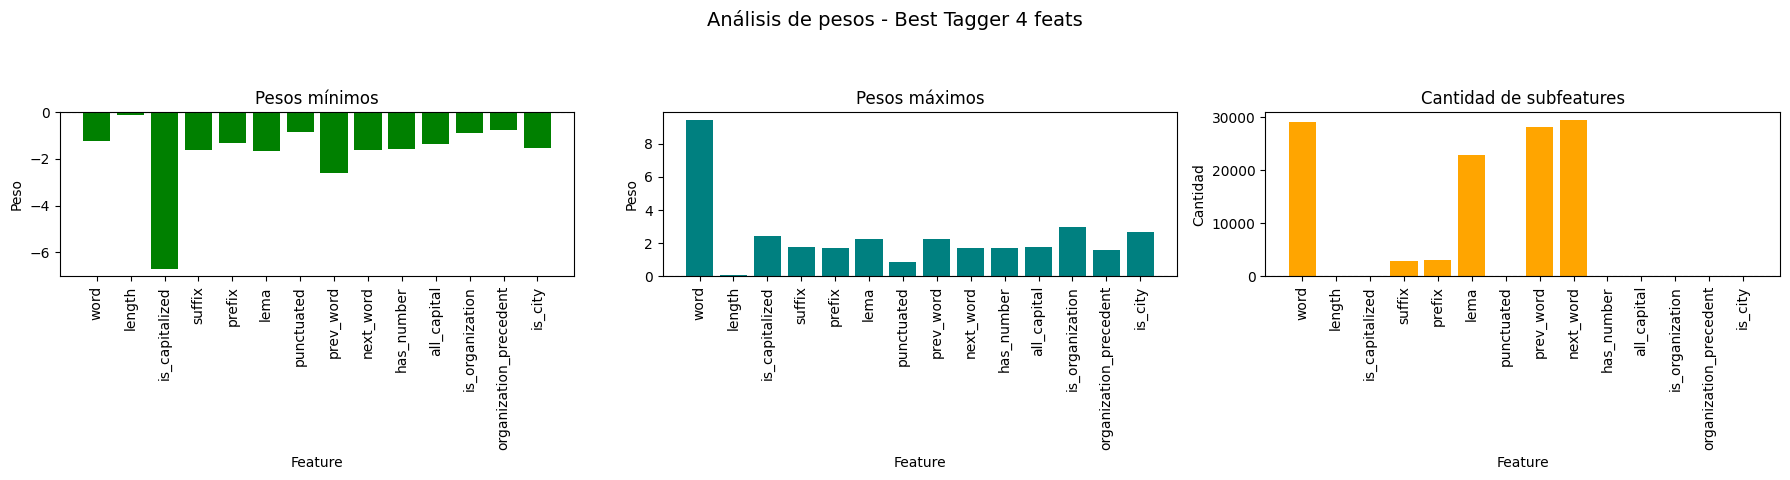

In [30]:
taggers = [besttagger]
titles = ["Best Tagger 4 feats"] 

for t_i, t in enumerate(taggers):
    D = {}

    for k, v in t.info().state_features.items():
        e, _ = k
        if ":" in e:
            e = e.split(":")[0]
        if e in D:
            D[e].append(v)
        else:
            D[e] = [v]

    D_max = {k: max(v) for k, v in D.items()}
    D_min = {k: min(v) for k, v in D.items()}
    D_len = {k: len(v) for k, v in D.items()}

    # Crear una fila con 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Análisis de pesos - {titles[t_i]}", fontsize=14)

    # Subplot 1: Pesos mínimos
    axes[0].bar(D_min.keys(), D_min.values(), color='green')
    axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axes[0].set_title("Pesos mínimos")
    axes[0].set_ylabel("Peso")
    axes[0].set_xlabel("Feature")
    axes[0].tick_params(axis='x', rotation=90)

    # Subplot 2: Pesos máximos
    axes[1].bar(D_max.keys(), D_max.values(), color='teal')
    axes[1].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axes[1].set_title("Pesos máximos")
    axes[1].set_ylabel("Peso")
    axes[1].set_xlabel("Feature")
    axes[1].tick_params(axis='x', rotation=90)

    # Subplot 3: Cantidad de subfeatures
    axes[2].bar(D_len.keys(), D_len.values(), color='orange')
    axes[2].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axes[2].set_title("Cantidad de subfeatures")
    axes[2].set_ylabel("Cantidad")
    axes[2].set_xlabel("Feature")
    axes[2].tick_params(axis='x', rotation=90)

    plt.tight_layout(rect=[0, 0.03, 1, 0.92])  # Ajustar para que no se solape con suptitle
    plt.show()


Se ve que el modelo está basando sus decisiones principalmente en las palabras mismas y su contexto léxico inmediato. Se crea una mayor cantidad de features asociados a la palabra actual, la anterior o la siguiente. Esto, podria ser causa de un posible sobreajuste a los datos de entrenamiento. El modelo está aprendiendo patrones específicos de palabras en lugar de patrones gramaticales o estructurales más generales. El modelo podría funcionar bien con vocabulario visto durante el entrenamiento pero fallar con palabras nuevas.

Además, se consideran bastante importantes todas las features básicas, menos la feature que indica si la palabra tiene un número o no.

Podemos ver como afectan las características específicas. Vamos a analizar los pesos que aporta el modelo a estas features. Necesitamos que la etiqueta que, en este caso ORG y LOC, tenga un peso grande y positivo ya que entonces el modelo aporta mucha probabilidad a favor de esta etiqueta, y además queremos que el peso de la feature para las demás etiquetas sea negativo para bajar la probabilidad de las etiquetas incorrectas. 

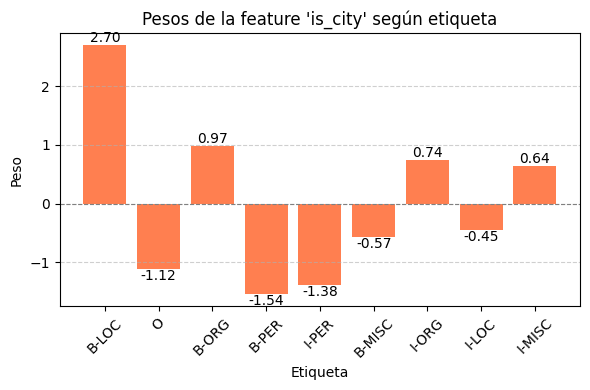

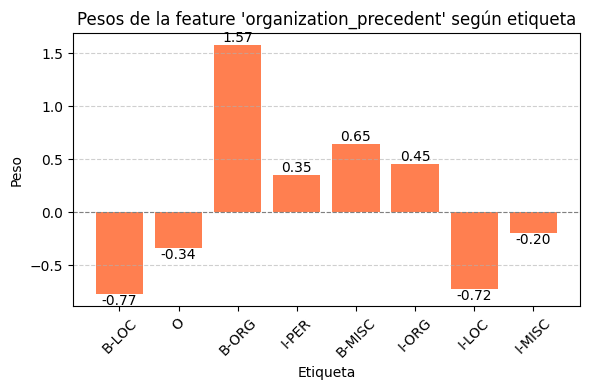

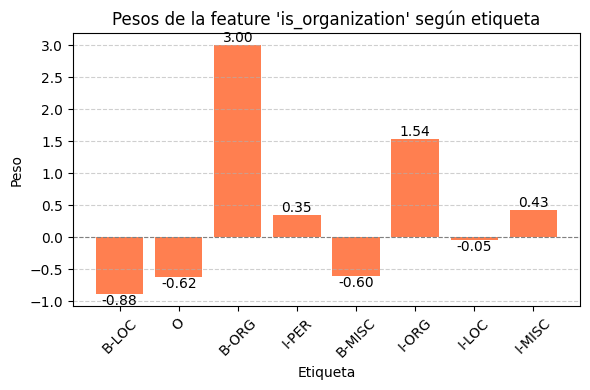

In [33]:

feature_general = ["is_city","organization_precedent","is_organization"]
weights = besttagger.info().state_features
for f in feature_general:
    # Extraemos etiquetas y pesos
    labels = []
    values = []

    for (feature_label, tag), weight in weights.items():
        if feature_label.startswith(f):
            labels.append(tag)
            values.append(weight)

    # Gráfico
    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, values, color='coral')
    plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
    plt.title(f"Pesos de la feature '{f}' según etiqueta")
    plt.ylabel("Peso")
    plt.xlabel("Etiqueta")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Mostrar valor en cada barra
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2f}', ha='center',
                va='bottom' if value >= 0 else 'top')

    plt.tight_layout()
    plt.show()

Vemos que el modelo usa el bloque de las características específicas para aprender las probabilidades, también, de otras etiquetas que no se refieren a las entidades de organización ni localización. Este comportamiento puede ser adecuado para las etiquetas micelanas, pero podría introducir ruido en el caso de otras etiquetas.

- El modelo al Gazzetter relacionado con el país aporta correctamente bastante peso a la etiqueta del inicio de organización, pero podría aportar ruido ya que le asigna peso a las etiquetas "B-ORG" y "I-MISC", sin embargo este es un comportamiento bastante esperado ya que, como vimos en el fichero del train muchas palabras marcadas localizaciones podrían ser organizaciones a la vez.

- El modelo aporta un peso bastante significativo al Gazzetter con organizaciones (is_organization), a las etiquetas adecuadas. Con algo de ruido en las etiquetas "I-PER", "I-MISC".

- Los trigramas precedentes a las organizaciones aportan menos peso de todo el bloque de las características específicas. Puede ser debido a que otras características, como las palabras del contexto, ya estén captando esta información. También puede ser causa de la gran variablilidad de los trigramas precedentes y poca cobertura del Gazzetter ya que contiene solo unas pocas frases precedentes.

Además, analizaremos los pesos del feature "lema":

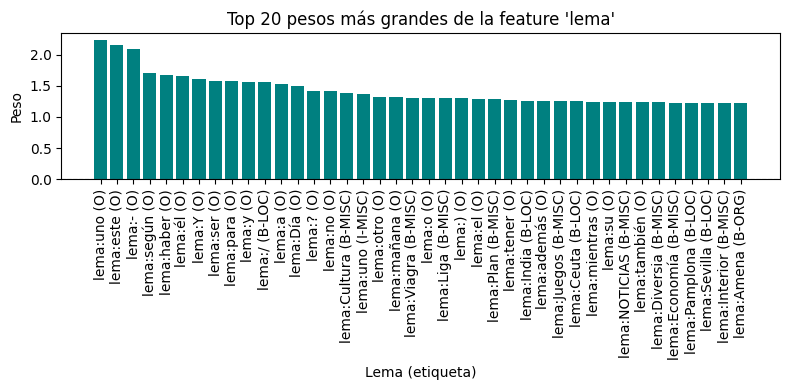

In [32]:
parsed_info = besttagger.info()
state_features = parsed_info.state_features

# Extraer solo los pesos de la feature 'lema'
lema_weights = {key: weight for key, weight in state_features.items() if key[0].startswith('lema')}

# Ordenar por el valor (no absoluto), de mayor a menor
top_20_lemas = sorted(lema_weights.items(), key=lambda x: x[1], reverse=True)[:40]

# Preparar datos para el plot
features = [f"{feature} ({label})" for (feature, label), weight in top_20_lemas]
weights = [weight for (feature, label), weight in top_20_lemas]

plt.figure(figsize=(8, 4))
bars = plt.bar(features, weights, color='teal')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Top 20 pesos más grandes de la feature 'lema'")
plt.ylabel("Peso")
plt.xlabel("Lema (etiqueta)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



- Los pesos de los lemas tienden a ser más moderados lo que podría significar que la información ya está captada por otros features, como por ejemplo "word" que en algunos casos tienen los mismos valores.
- Esta feature termina de captar las palabras no incluidas en los Gazzetters relacionados con la localización y las organizaciones. 
- Los lemas muestran pesos significativos para etiquetas "O", lo que significa que aportan a la desición de los límite de las entidades. 

## 9. Full Analysis with Optimized Features

Now that we've identified the best feature combinations, we can train a model with the optimal configuration and evaluate it on the full test set.

Buscamos los mejores features a base de addición, y lo avaluamos con los datos de validación, posteriormente obtenemos el modelo con mejor score F1 y lo predecimos para los datos test como validación del modelo.

In [36]:
# Example of running a complete analysis with the optimal feature configuration
def run_optimal_configuration(model_path=None, preprocessed_test = None, train_tags = None, otherTAG = None):
    """
    Run a complete analysis with the optimal feature configuration.
    
    Args:
        model_path: Optional path to a pre-trained model file. If provided, the model will be loaded
                   instead of being trained. For example: 'best_model_r4_B_C_C_L.crf.tagger'
    
    Returns:
        A tuple containing (tagger, evaluation_results)
    """
    # Create feature function with optimal settings (based on our findings)
    optimal_feat_func = OptimizedFeatFunc(
        use_Basic=True,
        use_context_words=True, 
        use_contex_POS_tag=True,
        use_lemas=True,  # Including lemmatization
        use_specific_caracteristics=False
    )
    
    # Initialize CRF tagger with our feature function
    optimal_tagger = CRFTagger(feature_func=optimal_feat_func)

    if train_tags: # CASO CUANDO SE QUIERE ENTRENAR EL MODELO CON CODIFICACIONES DIFERENTES A BIO

        optimal_tagger.train(train_tags, 'TAGS{otherTAG}_model.crf.tagger')
    
    print(f"Loading pre-trained model from {model_path}...")
        # Load the model instead of training
    optimal_tagger.set_model_file(model_path)
    
    print("Evaluating model on test data...")
    # Evaluate using entity-level metrics
    if train_tags:
        entity_results = entity_level_accuracy(optimal_tagger, preprocessed_test, otherTAG = otherTAG)
    else:
        entity_results = entity_level_accuracy(optimal_tagger, preprocessed_test)
    
    print("\n=== Entity-Level Evaluation Results ===")
    print(f"Precision: {entity_results['precision']:.4f}")
    print(f"Recall: {entity_results['recall']:.4f}")
    print(f"F1 Score: {entity_results['f1']:.4f}")

    # Create and display confusion matrix
    print("\n=== Entity-Level Confusion Matrix ===")
    plot_confusion_matrix(entity_results['confusion_matrix'], entity_results['entity_types'])
    
    return entity_results

## 10. Experiment with Different Tag Encoding Schemes

The BIO scheme is the most common, but let's implement functions to convert to other schemes.

**Esquemas:**

Esquema BIO (base de datos)
- B: Beginning (inicio de una entidad)
- I: Inside (continuación de una entidad)
- O: Outside (fuera de cualquier entidad)

IO
- I: Inside (token que pertenece a una entidad)
- O: Outside (token que no pertenece a una entidad)

BIOE
- B-: Beginning (primer token de una entidad)
- I-: Inside (tokens intermedios)
- E-: End (último token de una entidad)
- O: Outside (fuera de cualquier entidad)

BIOES
- B: Beginning (primer token de una entidad multi-token)
- I: Inside (tokens intermedios de una entidad multi-token)
- O: Outside (no es parte de ninguna entidad)
- E: End (último token de una entidad multi-token)
- S: Singleton (entidad de un solo token)

BIOW
- B: Beginning (primer token de una entidad multi-token)
- I: Inside (tokens intermedios de una entidad multi-token)
- O: Outside (no es parte de ninguna entidad)
- W: Whole (entidad de un solo token)

PROBLEMA CON IO ==> AMBIGUEDAD DE DONDE EMPIEZA PORQUE SI TUBIERAMOS DOS ENTIDADES SEGUIDAS, NO PODRÍAMOS DIFERENCIAR-LOS.

In [16]:
def bio_to_io(tagged_sent: List[Tuple[str, str, str]]) -> List[List[Tuple[str, str, str]]]:
    """Convert BIO tagging to IO tagging
    
    Args:
        tagged_sent: List of sentences where each sentence is a list of tuples (word, pos, tag) in BIO format.
        
    Returns:
        List of sentences where each sentence is a list of tuples (word, pos, tag) in IO format.
    """
    io_data = []
    for sentence in tagged_sent:
        io_sentence = []
        for word, pos, tag in sentence:
            if tag.startswith('B-'):
                # Replace B- with I- for any entity tag
                entity_type = tag[2:]
                io_sentence.append((word, pos, f"I-{entity_type}"))
            else:
                # Keep I- tags and O tags as they are
                io_sentence.append((word, pos, tag))
        io_data.append(io_sentence)
    return io_data

def bio_to_bioe(tagged_sent: List[List[Tuple[str, str, str]]]) -> List[List[Tuple[str, str, str]]]:
    """Convert BIO tagging to BIOE tagging (BIOE incluye E to indicate the end of an entity)
    Args:
        tagged_sent: List of sentences where each sentence is a list of tuples (word, pos, tag) in BIO format.
        
    Returns:
        List of sentences where each sentence is a list of tuples (word, pos, tag) in BIOE format.
    """
    bioe_data = []
    for sentence in tagged_sent:
        bioe_sentence = []
        n = len(sentence)
        i = 0
        while i < n:
            word, pos, tag = sentence[i]
            
            if tag.startswith('B-'):
                entity_type = tag[2:]
                
                # Find the end of the entity
                j = i + 1
                is_multi_token = False
                while j < n and sentence[j][2] == f"I-{entity_type}":
                    is_multi_token = True
                    j += 1
                
                # Add the B- tag
                bioe_sentence.append((word, pos, tag))
                
                # Process all intermediate I- tags
                for k in range(i + 1, j - 1):
                    bioe_sentence.append(sentence[k])
                
                # Convert the last I- tag to E- if this is a multi-token entity
                if is_multi_token:
                    last_word, last_pos, last_tag = sentence[j - 1]
                    bioe_sentence.append((last_word, last_pos, f"E-{entity_type}"))
                    i = j
                else:
                    i += 1
            else:
                bioe_sentence.append((word, pos, tag))
                i += 1
                
        bioe_data.append(bioe_sentence)
    return bioe_data

def bio_to_bioes(tagged_sent: List[List[Tuple[str, str, str]]]) -> List[List[Tuple[str, str, str]]]:
    """Convert BIO tagging to BIOES tagging
    Args:
        tagged_sent: List of sentences where each sentence is a list of tuples (word, pos, tag) in BIO format.
        
    Returns:
        List of sentences where each sentence is a list of tuples (word, pos, tag) in BIOES format.
    """
    bioes_data = []
    for sentence in tagged_sent:
        bioes_sentence = []
        n = len(sentence)
        i = 0
        while i < n:
            word, pos, tag = sentence[i]
            
            if tag.startswith('B-'):
                entity_type = tag[2:]
                
                # Check if it's a singleton entity (no following I- tags)
                if i + 1 == n or not sentence[i+1][2].startswith(f"I-{entity_type}"):
                    bioes_sentence.append((word, pos, f"S-{entity_type}"))
                    i += 1
                else:
                    # It's the beginning of a multi-token entity
                    bioes_sentence.append((word, pos, tag))
                    i += 1
                    
                    # Process all the intermediate I- tags
                    while i < n and sentence[i][2] == f"I-{entity_type}":
                        # Check if this is the last I- tag
                        if i + 1 == n or sentence[i+1][2] != f"I-{entity_type}":
                            # Change last I- tag to E- tag
                            word_i, pos_i, _ = sentence[i]
                            bioes_sentence.append((word_i, pos_i, f"E-{entity_type}"))
                        else:
                            bioes_sentence.append(sentence[i])
                        i += 1
            else:
                bioes_sentence.append((word, pos, tag))
                i += 1
                
        bioes_data.append(bioes_sentence)
    return bioes_data

def bio_to_biow(tagged_sent: List[List[Tuple[str, str, str]]]) -> List[List[Tuple[str, str, str]]]:
    """Convert BIO tagging to BIOW tagging (BIOW incluye W to indicate single-token entities)
    Args:
        tagged_sent: List of sentences where each sentence is a list of tuples (word, pos, tag) in BIO format.
        
    Returns:
        List of sentences where each sentence is a list of tuples (word, pos, tag) in BIOW format.
    """
    biow_data = []
    for sentence in tagged_sent:
        biow_sentence = []
        n = len(sentence)
        
        for i, (word, pos, tag) in enumerate(sentence):
            if tag.startswith('B-'):
                entity_type = tag[2:]
                # Check if it's a single-token entity
                if (i + 1 == n) or (not sentence[i+1][2].startswith(f"I-{entity_type}")):
                    biow_sentence.append((word, pos, f"W-{entity_type}"))
                else:
                    biow_sentence.append((word, pos, tag))
            else:
                biow_sentence.append((word, pos, tag))
                
        biow_data.append(biow_sentence)
    return biow_data


NO HACE FALTA TRANSFORMAR TEST A OTROS TAGS PORQUE PARA PREDECIR SOLO NECESITA LOS FEATURES Y NO LOS TAGS.

In [17]:
## hay que guardar los modelos de tags y las salidas.
def test_with_othersCodes(train, preprocessed_test, best_model_path):
    Codes = ['BIO', 'IO', 'BIOE', 'BIOES', 'BIOW']
    test_results = {}
    
    '''# Extract entities from test data (for comparison)
    test_entities = {}
    for i in range(len(preprocessed_test)):
        sentence = preprocessed_test[i]
        test_tags = []
        
        for j in range(len(sentence)):
            # Extract the tag from each word
            test_tags.append(sentence[j][1])
            
        # Store entities from original test data
        test_entities[i] = extract_entities(test_tags)'''

    # Test each tagging scheme
    for scheme in Codes[1:]:
        print(f"\nProcessing {scheme} tagging scheme...")
        
        # Convert training data to the current scheme
        if scheme == 'IO':
            train_tag_data = bio_to_io(train)
        elif scheme == 'BIOE':
            train_tag_data = bio_to_bioe(train)
        elif scheme == 'BIOES':
            train_tag_data = bio_to_bioes(train)
        elif scheme == 'BIOW':
            train_tag_data = bio_to_biow(train)
            
        # Process the converted training data for CRF
        preprocessed_train_tags = prepare_data_for_crf(train_tag_data, True)
        
        # Train a new model with this tagging scheme
        print(f"Training model with {scheme} tagging scheme...")
        scheme_model_path = f'{scheme}_model.crf.tagger'
        
        results = run_optimal_configuration(model_path=best_model_path, 
                                            preprocessed_test=preprocessed_test, 
                                            train_tags=preprocessed_train_tags, 
                                            otherTAG = scheme)
        # Store results
        test_results[scheme] = results
        
        # Print results
        print(f"\nResults for {scheme} tagging scheme:")
        print(f"Precision: {results['precision']:.4f}")
        print(f"Recall: {results['recall']:.4f}")
        print(f"F1 Score: {results['f1']:.4f}")
        
    # Compare results
    print("\n=== Comparison of Tagging Schemes ===")
    schemes = ['BIO'] + Codes[1:]
    metrics = ['precision', 'recall', 'f1']
    
    # Add BIO results (default)
    bio_results = run_optimal_configuration(best_model_path, preprocessed_test)
    test_results['BIO'] = bio_results
    
    # Create DataFrame for plotting
    results_df = pd.DataFrame({
        scheme: {metric: test_results[scheme][metric] for metric in metrics}
        for scheme in schemes
    })
    
    # Plot comparison
    results_df.plot(kind='bar', figsize=(12, 6))
    plt.title('Performance Comparison of Different Tagging Schemes')
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    return test_results

## Conclusion

In this notebook, we've demonstrated:

1. How to use the custom `data` class to process NER data and extract lemmas
2. Implementing a feature function class with various customizable feature sets
3. Training and evaluating CRF models for NER with different feature combinations
4. Converting between different tagging schemes (BIO, IO, BIOES)
5. Entity-level evaluation for more accurate performance measurement
6. Systematic analysis of feature importance for NER performance

The entity-level evaluation provides a more meaningful assessment of NER performance than token-level accuracy, as it ensures that complete entities are correctly identified rather than just individual tokens.

========================Loading Spanish NER data...=================================
Training set: 8323 sentences
Test set: 1517 sentences
Validation set: 1915 sentences

Example sentence:
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]
Original:
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Processed (with lemmas):
[(('Melbourne', 'NP', 'Melbourne'), 'B-LOC'), (('(', 'Fpa', '('), 'O'), (('Australia', 'NP', 'Australia'), 'B-LOC'), ((')', 'Fpt', ')'), 'O'), ((',', 'Fc', ','), 'O'), (('25', 'Z', '25'), 'O'), (('may', 'NC', 'may'), 'O'), (('(', 'Fpa', '('), 'O'), (('EFE', 'NC', 'EFE'), 'B-ORG'), ((')', 'Fpt', ')'), 'O'

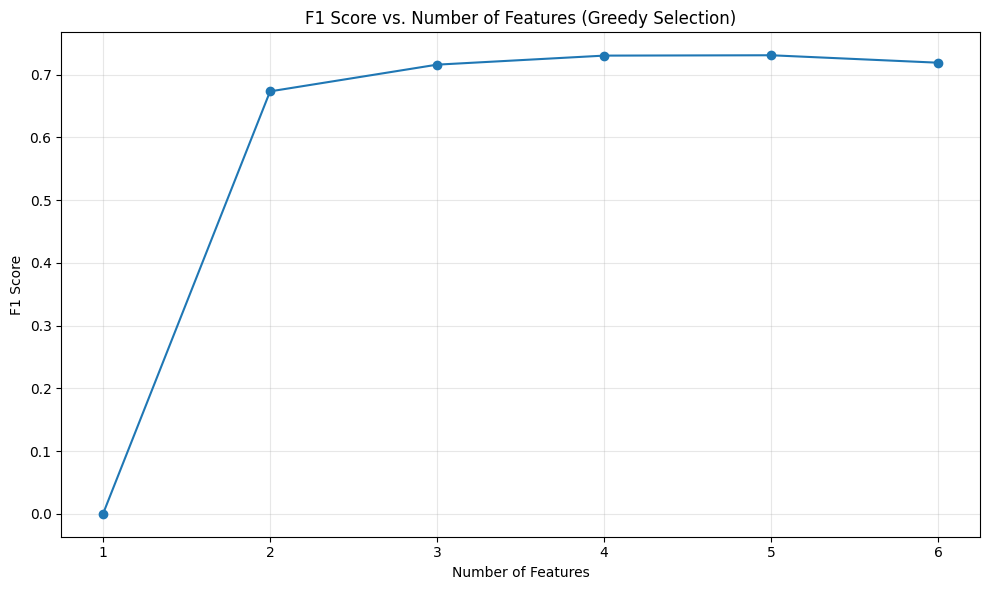

Loading pre-trained model from NEWbest_model_r4_B_C_L_S.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Entity-Level Confusion Matrix ===


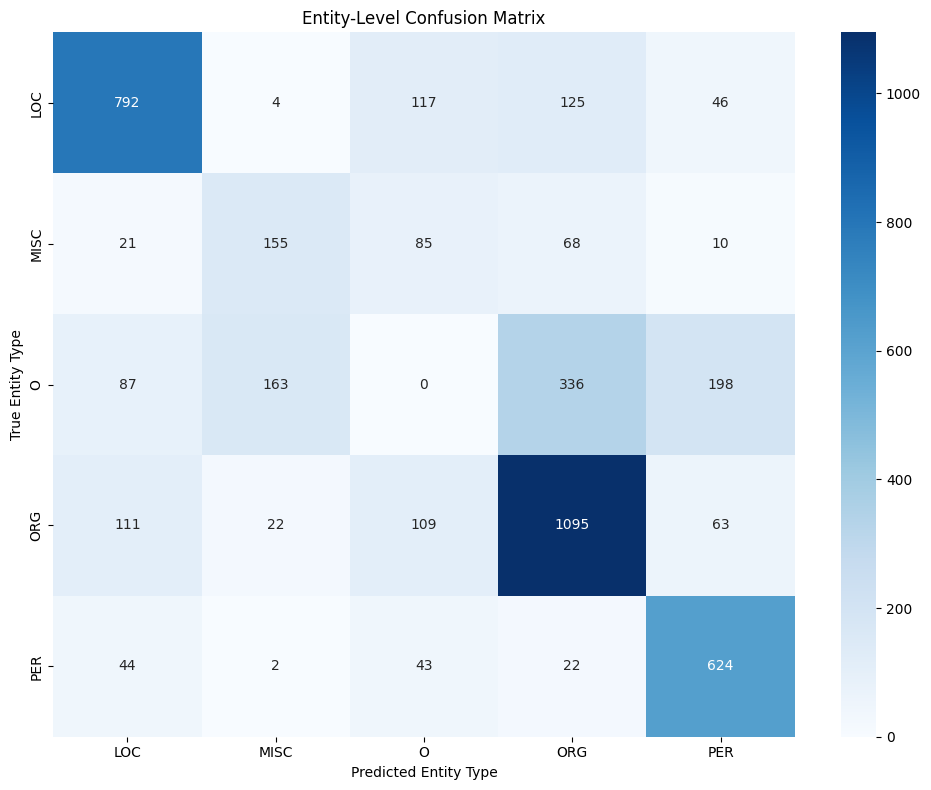


Most common entity type confusions:
  O mistaken as ORG: 336 times
  O mistaken as PER: 198 times
Original (BIO):
[('Por', 'SP', 'O'), ('su', 'DP', 'O'), ('parte', 'NC', 'O'), (',', 'Fc', 'O'), ('el', 'DA', 'O'), ('Abogado', 'NC', 'B-PER'), ('General', 'AQ', 'I-PER'), ('de', 'SP', 'O'), ('Victoria', 'NC', 'B-LOC'), (',', 'Fc', 'O'), ('Rob', 'NC', 'B-PER'), ('Hulls', 'AQ', 'I-PER'), (',', 'Fc', 'O'), ('indicó', 'VMI', 'O'), ('que', 'CS', 'O'), ('no', 'RN', 'O'), ('hay', 'VAI', 'O'), ('nadie', 'PI', 'O'), ('que', 'PR', 'O'), ('controle', 'VMS', 'O'), ('que', 'CS', 'O'), ('las', 'DA', 'O'), ('informaciones', 'NC', 'O'), ('contenidas', 'AQ', 'O'), ('en', 'SP', 'O'), ('CrimeNet', 'NC', 'B-MISC'), ('son', 'VSI', 'O'), ('veraces', 'AQ', 'O'), ('.', 'Fp', 'O')]

IO Scheme:
[('Por', 'SP', 'O'), ('su', 'DP', 'O'), ('parte', 'NC', 'O'), (',', 'Fc', 'O'), ('el', 'DA', 'O'), ('Abogado', 'NC', 'I-PER'), ('General', 'AQ', 'I-PER'), ('de', 'SP', 'O'), ('Victoria', 'NC', 'I-LOC'), (',', 'Fc', 'O'), ('

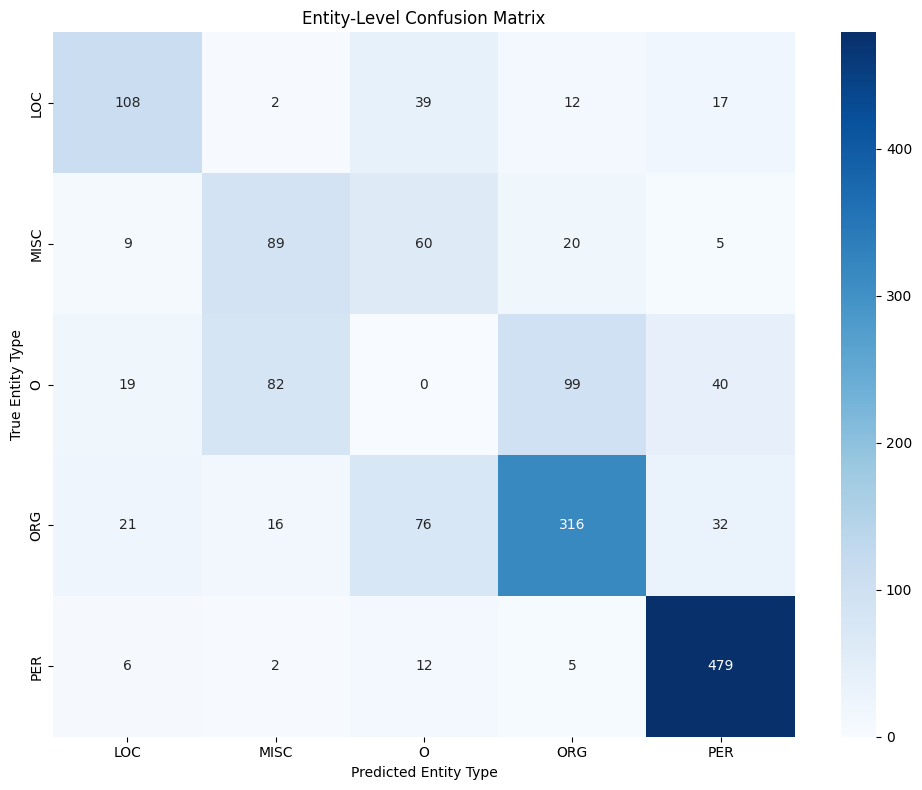


Most common entity type confusions:
  O mistaken as ORG: 99 times

Results for IO tagging scheme:
Precision: 0.7702
Recall: 0.7481
F1 Score: 0.7590

Processing BIOE tagging scheme...
Training model with BIOE tagging scheme...
Loading pre-trained model from NEWbest_model_r4_B_C_L_S.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Entity-Level Confusion Matrix ===


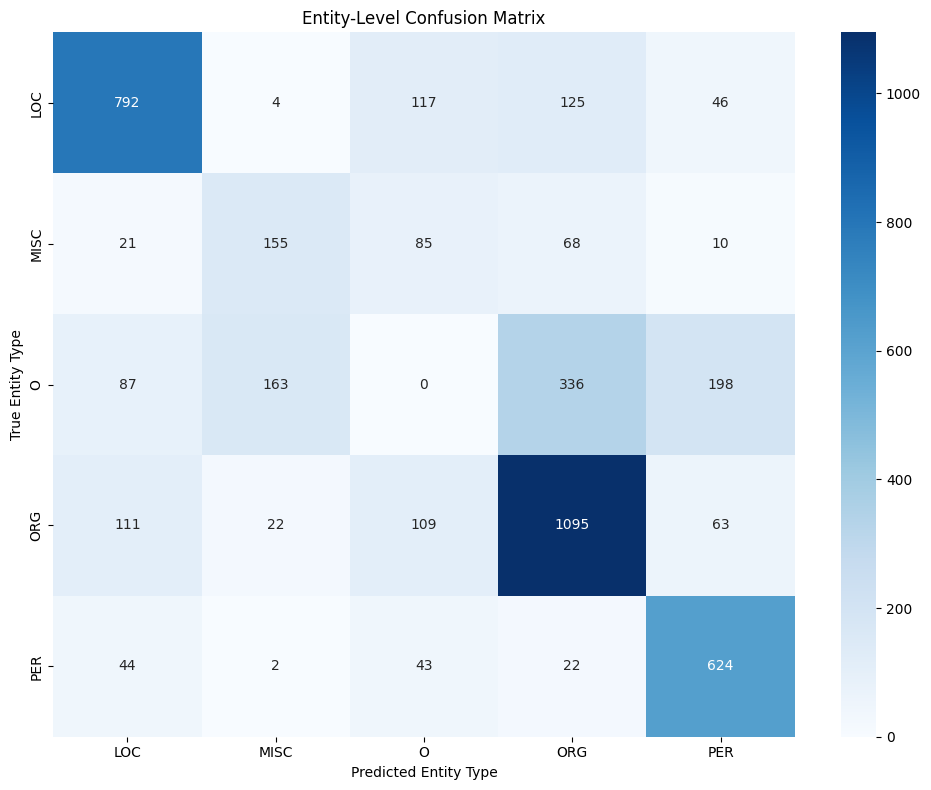


Most common entity type confusions:
  O mistaken as ORG: 336 times
  O mistaken as PER: 198 times

Results for BIOE tagging scheme:
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

Processing BIOES tagging scheme...
Training model with BIOES tagging scheme...
Loading pre-trained model from NEWbest_model_r4_B_C_L_S.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Entity-Level Confusion Matrix ===


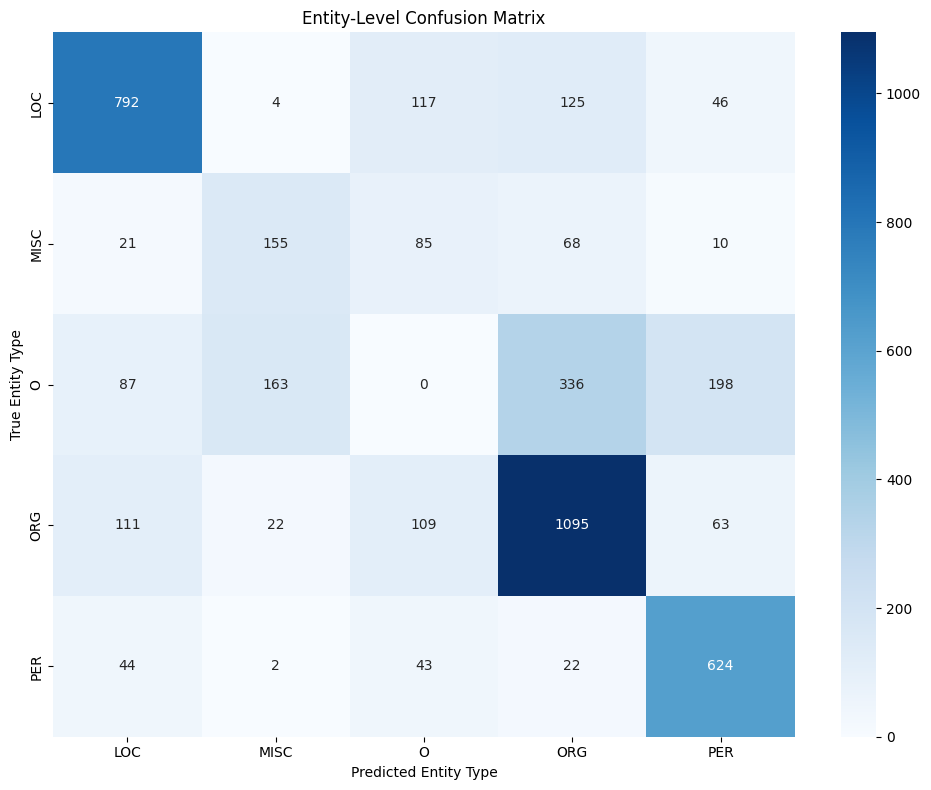


Most common entity type confusions:
  O mistaken as ORG: 336 times
  O mistaken as PER: 198 times

Results for BIOES tagging scheme:
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

Processing BIOW tagging scheme...
Training model with BIOW tagging scheme...
Loading pre-trained model from NEWbest_model_r4_B_C_L_S.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Entity-Level Confusion Matrix ===


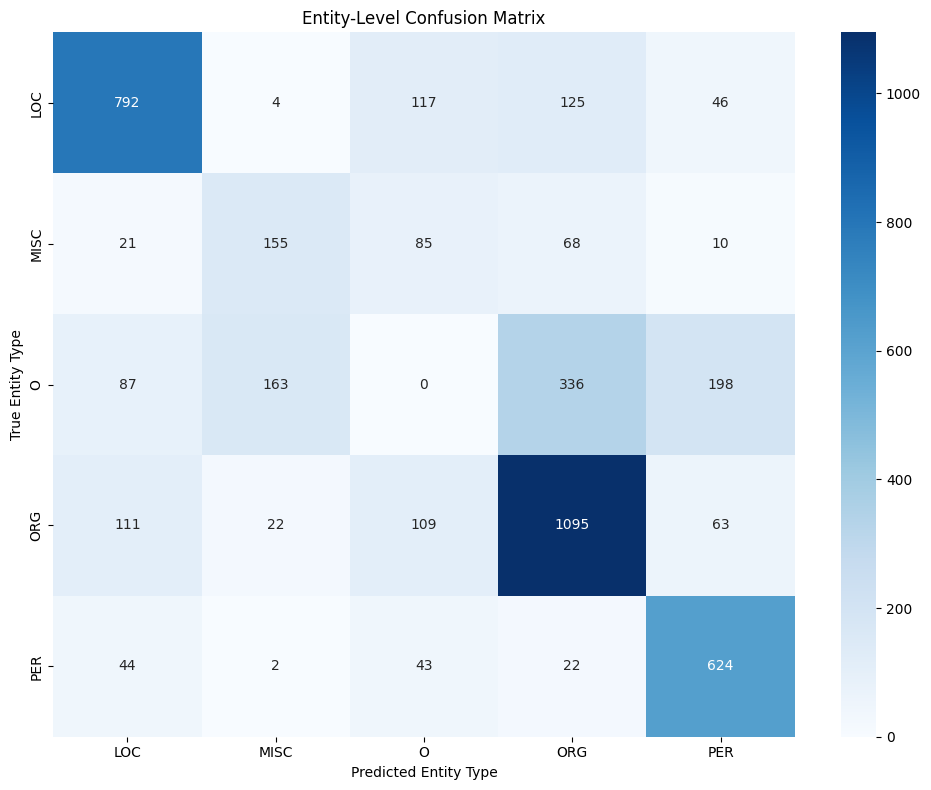


Most common entity type confusions:
  O mistaken as ORG: 336 times
  O mistaken as PER: 198 times

Results for BIOW tagging scheme:
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Comparison of Tagging Schemes ===
Loading pre-trained model from NEWbest_model_r4_B_C_L_S.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Entity-Level Confusion Matrix ===


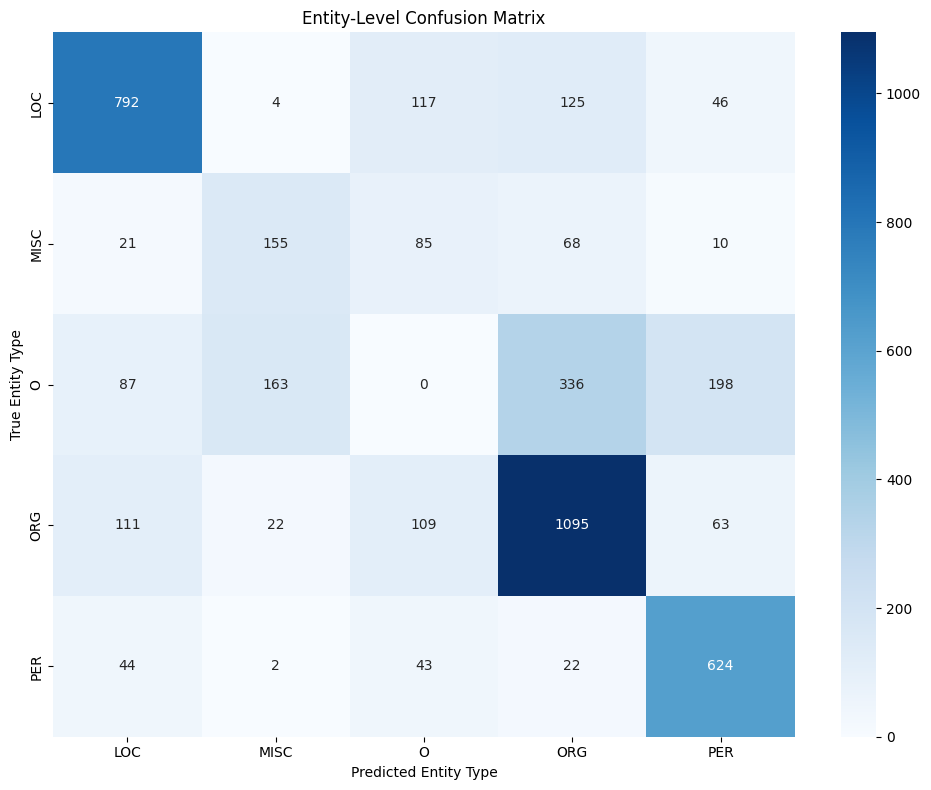


Most common entity type confusions:
  O mistaken as ORG: 336 times
  O mistaken as PER: 198 times


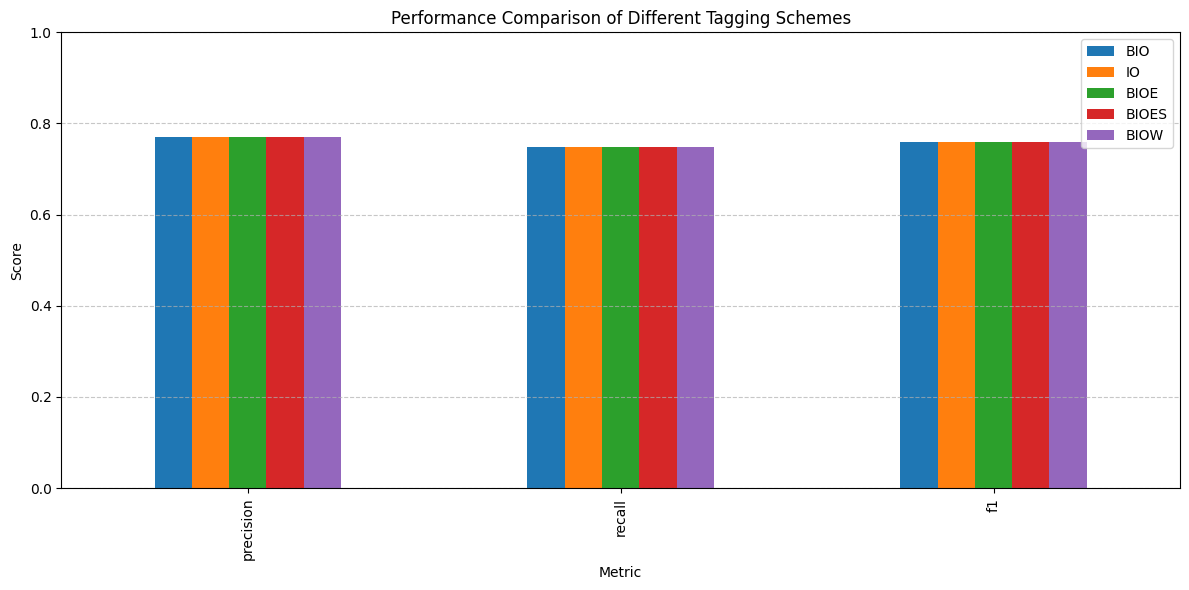

In [ ]:
if __name__== "__main__":
    # Run the main function
    # Load the Spanish NER data
    print("========================Loading Spanish NER data...=================================")
    val = conll2002.iob_sents('esp.testa')
    test = conll2002.iob_sents('esp.testb')

    print(f"Training set: {len(train)} sentences")
    print(f"Test set: {len(test)} sentences")
    print(f"Validation set: {len(val)} sentences")

    # Show an example sentence
    print("\nExample sentence:")
    print(train[0])

    #process the training data with lemmatization 
    processed_train = prepare_data_for_crf(train, include_lemmas=True)
    preprocessed_val = prepare_data_for_crf(val, True)
    preprocessed_test = prepare_data_for_crf(test, True)

    # Show the first processed sentence
    print("Original:")
    print(train[0])
    print("\nProcessed (with lemmas):")
    print(processed_train[0])

    train_completo(processed_train=processed_train, processed_val=preprocessed_val)

    best_model_path = 'Modelos_Spanish/best_model_r4_B_C_L_S.crf.tagger'
    results = run_optimal_configuration(model_path=best_model_path, preprocessed_test=preprocessed_test)

    # Example of converting tags
    sample_sent = [train[5]]  # Wrap in list to match expected input structure
    print("Original (BIO):")
    print(sample_sent[0])

    io_sent = bio_to_io(sample_sent)
    print("\nIO Scheme:")
    print(io_sent[0])

    bioes_sent = bio_to_bioes(sample_sent)
    print("\nBIOES Scheme:")
    print(bioes_sent[0])

    test_results = test_with_othersCodes(train=train, 
                                         preprocessed_test=preprocessed_test, 
                                         best_model_path=best_model_path)




In [37]:
print("========================Loading Dutch NER data...=================================")
    # Load the Dutch NER data
dutch_train = conll2002.iob_sents('ned.train')
dutch_val = conll2002.iob_sents('ned.testa')
dutch_test = conll2002.iob_sents('ned.testb')
print("Preparing Dutch data...")
processed_dutch_train = prepare_data_for_crf(dutch_train, include_lemmas=True)
preprocessed_dutch_val = prepare_data_for_crf(dutch_val, True)
preprocessed_dutch_test = prepare_data_for_crf(dutch_test, True)
print("Training Dutch model...")
train_completo(processed_train=processed_dutch_train, processed_val=preprocessed_dutch_val)
best_model = 'modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger'
results = run_optimal_configuration(model_path=best_model, preprocessed_test=preprocessed_dutch_test)
print("Evaluating Dutch model with other TAGS...")
test_results = test_with_othersCodes(train=dutch_train, 
                                        preprocessed_test=preprocessed_dutch_test, 
                                        best_model_path=best_model)

========================Loading Dutch NER data...=================================
Preparing Dutch data...


KeyboardInterrupt: 

Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Entity-Level Confusion Matrix ===


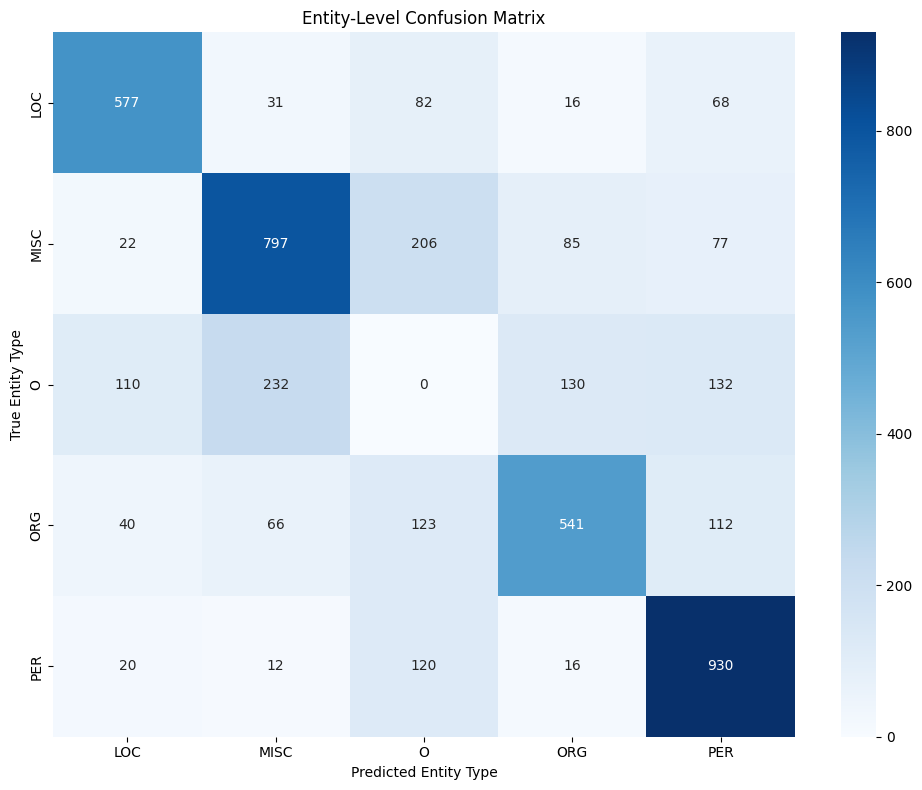


Most common entity type confusions:
  O mistaken as MISC: 232 times

Processing IO tagging scheme...
Training model with IO tagging scheme...
Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7547
Recall: 0.7413
F1 Score: 0.7480

=== Entity-Level Confusion Matrix ===


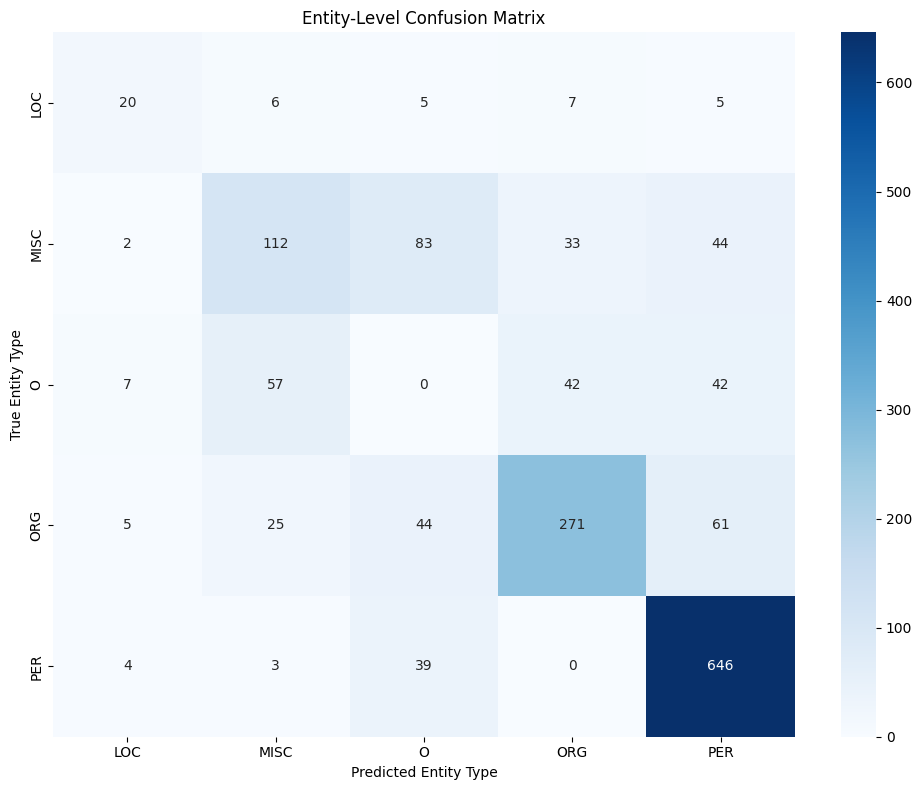


Most common entity type confusions:
  MISC mistaken as O: 83 times
  ORG mistaken as PER: 61 times

Results for IO tagging scheme:
Precision: 0.7547
Recall: 0.7413
F1 Score: 0.7480

Processing BIOE tagging scheme...
Training model with BIOE tagging scheme...
Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Entity-Level Confusion Matrix ===


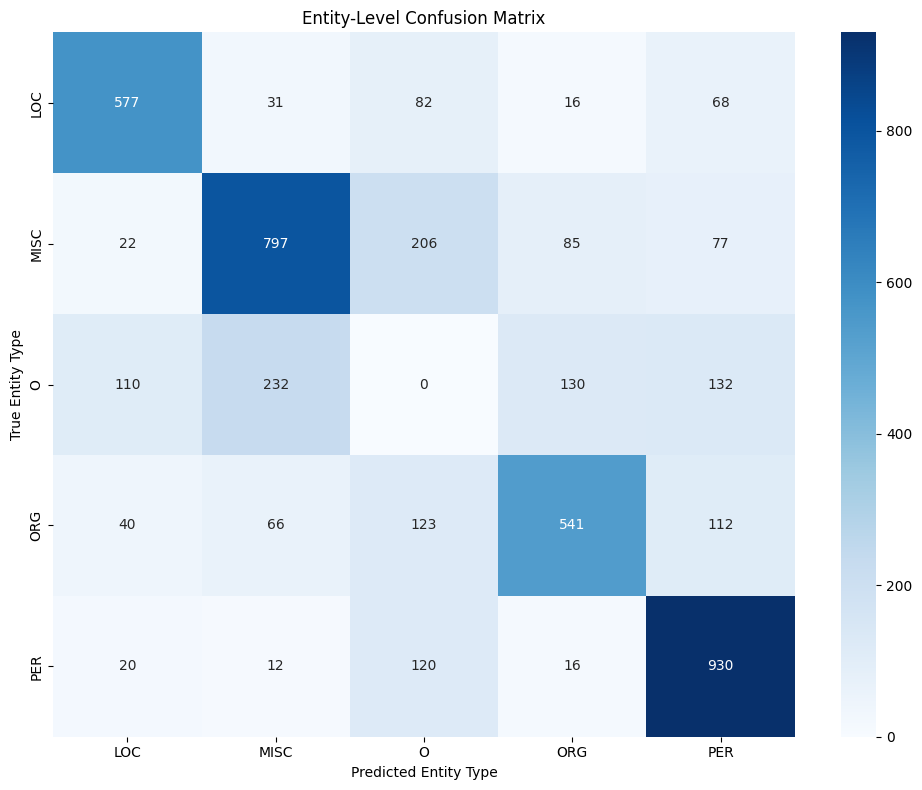


Most common entity type confusions:
  O mistaken as MISC: 232 times

Results for BIOE tagging scheme:
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

Processing BIOES tagging scheme...
Training model with BIOES tagging scheme...
Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Entity-Level Confusion Matrix ===


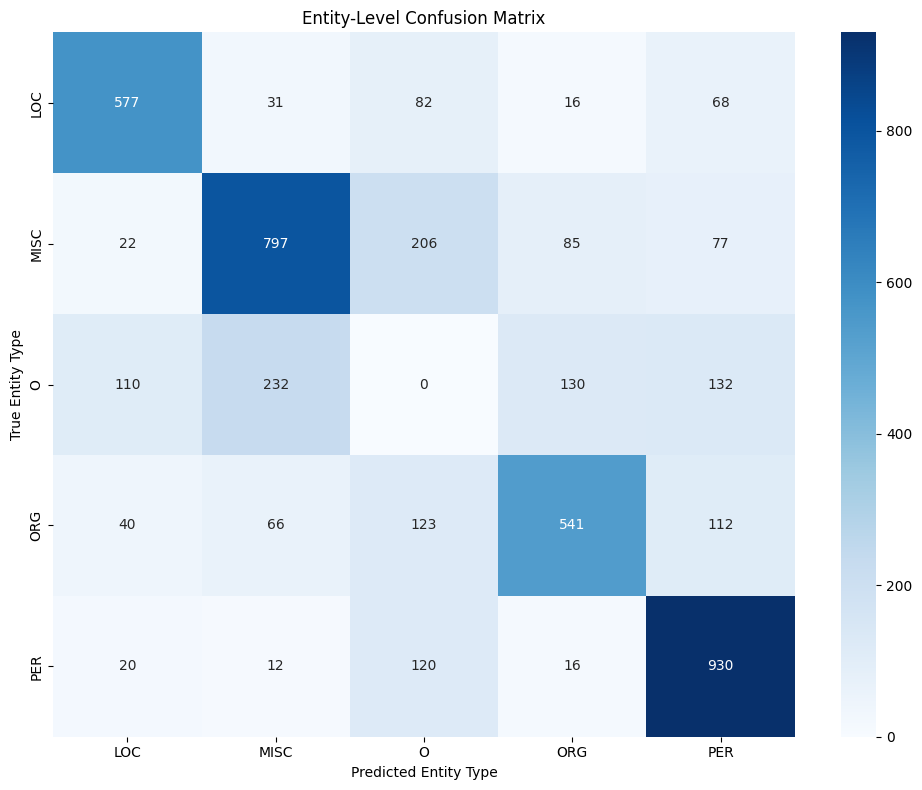


Most common entity type confusions:
  O mistaken as MISC: 232 times

Results for BIOES tagging scheme:
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

Processing BIOW tagging scheme...
Training model with BIOW tagging scheme...
Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Entity-Level Confusion Matrix ===


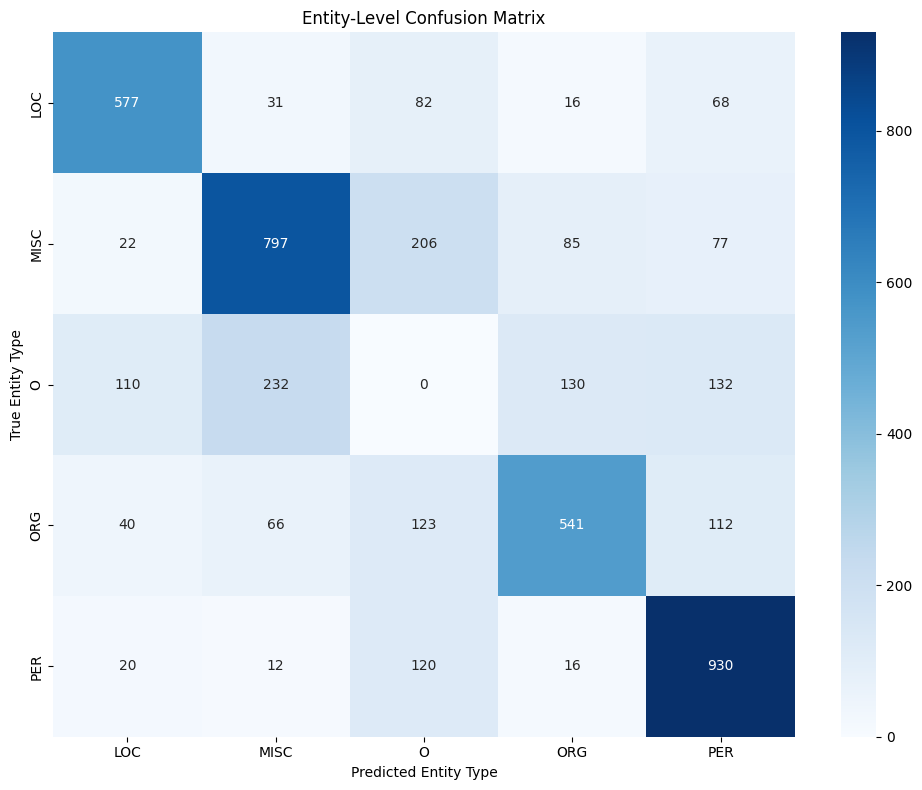


Most common entity type confusions:
  O mistaken as MISC: 232 times

Results for BIOW tagging scheme:
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Comparison of Tagging Schemes ===
Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Entity-Level Confusion Matrix ===


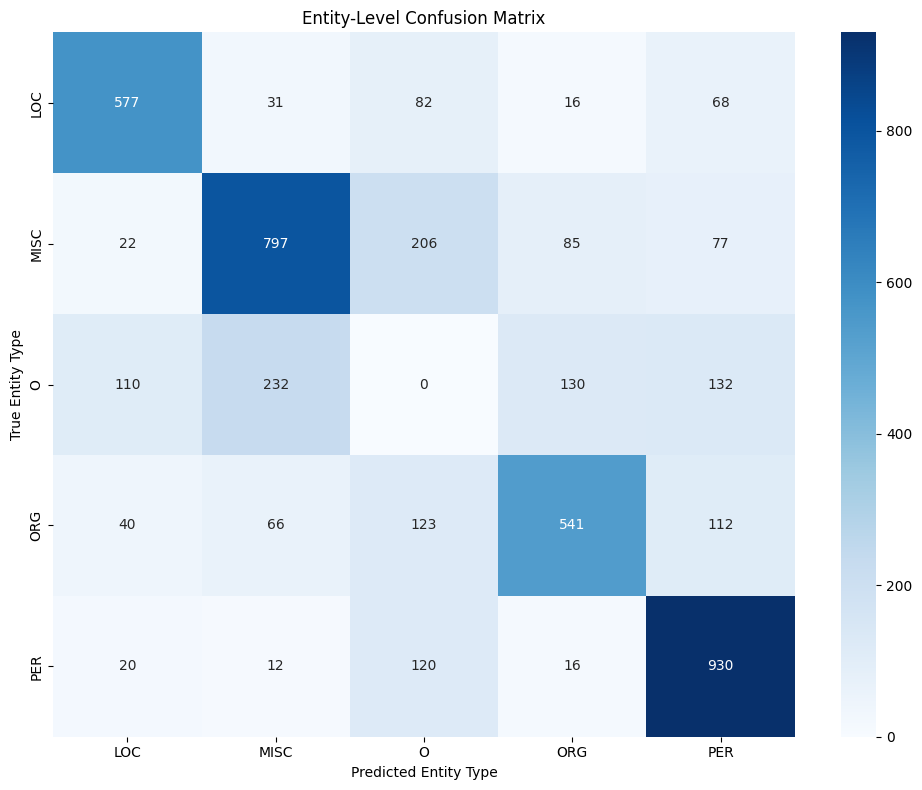


Most common entity type confusions:
  O mistaken as MISC: 232 times


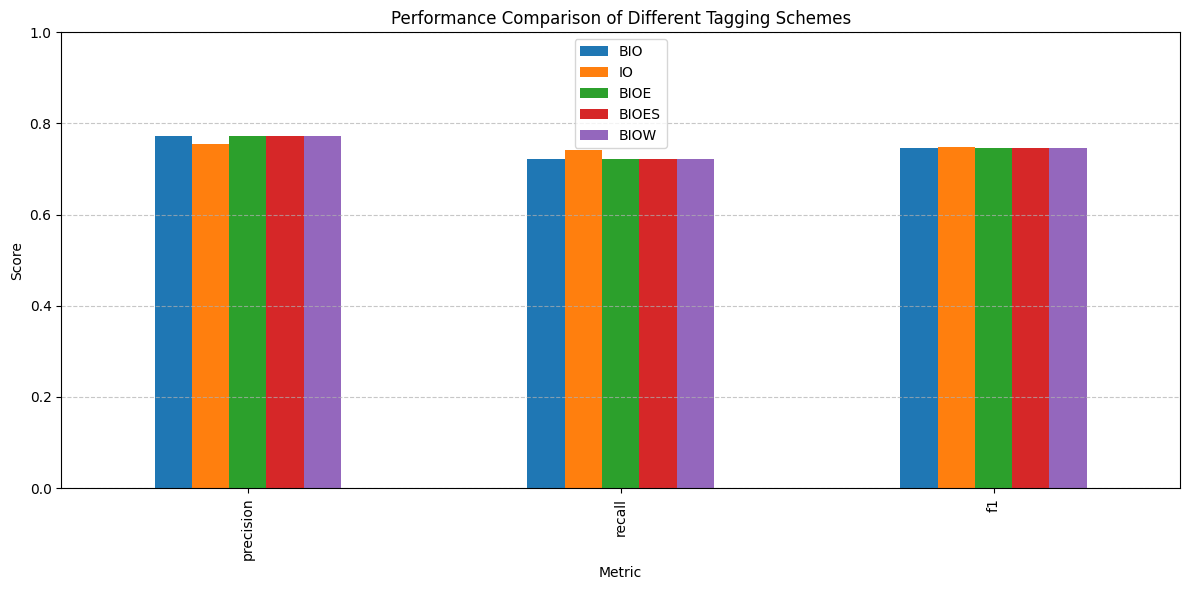

In [38]:
best_model = 'modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger'

results = run_optimal_configuration(model_path=best_model, preprocessed_test=preprocessed_dutch_test)

test_results = test_with_othersCodes(train=dutch_train, 
                                        preprocessed_test=preprocessed_dutch_test, 
                                        best_model_path=best_model)

[('Dat', 'Pron', 'O'), ('is', 'V', 'O'), ('in', 'Prep', 'O'), ('Italië', 'N', 'B-LOC'), (',', 'Punc', 'O'), ('Spanje', 'N', 'B-LOC'), ('of', 'Conj', 'O'), ('Engeland', 'N', 'B-LOC'), ('misschien', 'Adv', 'O'), ('geen', 'Pron', 'O'), ('probleem', 'N', 'O'), (',', 'Punc', 'O'), ('maar', 'Conj', 'O'), ('volgens', 'Prep', 'O'), ("'", 'Punc', 'O'), ('Der', 'N', 'B-PER'), ('Kaiser', 'N', 'I-PER'), ("'", 'Punc', 'O'), ('in', 'Prep', 'O'), ('Duitsland', 'N', 'B-LOC'), ('wel', 'Adv', 'O'), ('.', 'Punc', 'O')]
